In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import random
from tqdm import tqdm

import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from typing import List
from collections import Counter
from scipy.integrate import solve_ivp

# The SIR model

We will focus on the SIR model, probably the most studied model in computational epidemics. In its simplest form, the SIR model can be defined as follows. A large population of $N$ individuals is divided into three classes:
+ **Susceptible** individuals (S): those who do not have the disease but can get it.
+ **Infected** individuals (I) : those who have the disease.
+ **Recovered** individuals (R): those who cannot get the disease anymore.

The basic dynamics of the model are simple as well:
1. Susceptible individuals might get infected if they are in contact with an infected individual. 
2. Infected individuals become recovered after some time. 

Notice that individuals can only go from *S* to *I* and from *I* to *R*. We will also assume that infective individuals have contacts with randomly chosen individuals of all states at an average rate $\beta$ per unit time, and recover and acquire immunity (or die) at an average rate $\gamma$ per unit time. 


### Fully mixed population
If we assume a very large population that is **fully mixed**, then the model can be descrived by a set of coupled nonlinear differential equations:  


<img src="attachment:image.png" width="400"> 

### Exercise 5.1
The `scipy.integrate` library has a function `solve_ip` that can be used to solve initial value problems for systems of ODES.
The documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

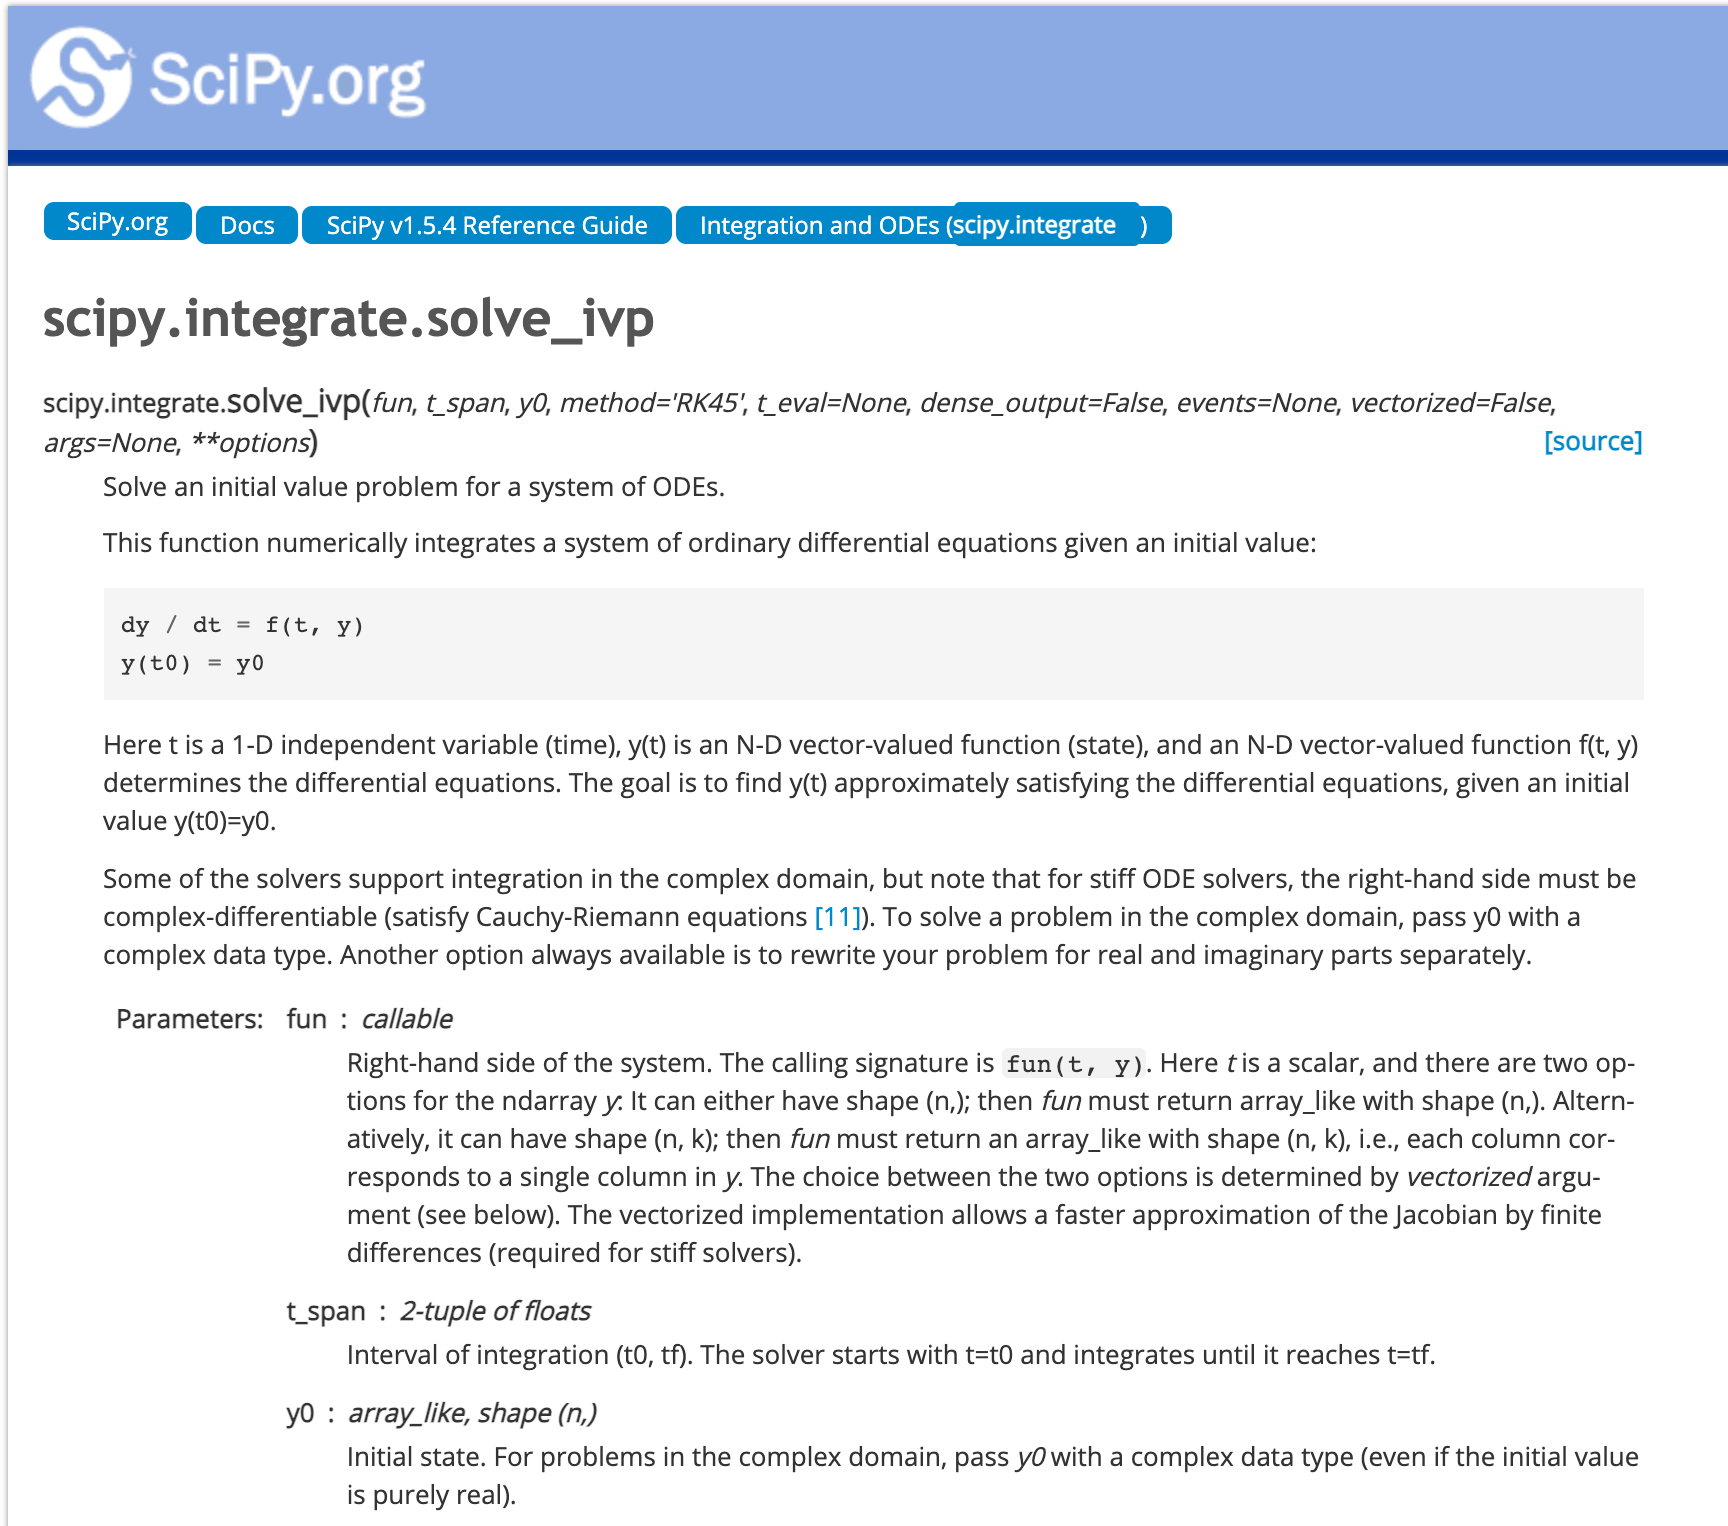


Read the documentation and try to understand how to use `solve_ivp`. The key bit is to notice that we have to write a **function** `f(t, y)`  whose first argument is the timepoint `t` and whose second argument `y` is a numpy array. In our case, y will have dimension 3. Do you see why?


The Initial Value Problem to be solved is then simply

```text
    dy / dt = f(t, y)
    y(t0) = y0
```


Write a function `ode_SIR` that represents the system of differential equations of a SIR model and follows the specification of `solve_ivp`.

In [2]:
def odes_SIR(t, y):
    """
    The main ODE equations of the SIR model
    """
    S, I, R = y[0], y[1], y[2]
    N = S+I+R
    f=np.array([
        - beta * (I/N) * S ,
        beta * (I/N) * S - gamma * I,
        gamma * I,        
    ])
    return f


### Exercise 5.2
Use `solve_ivp` and your `ode_SIR` function to study the behaviour of the SIR model for different values of the parameters, and describe your findings with a short paragraph.

In [3]:
# set parameters
beta=0.1
gamma=0.03
y0 = (100000, 1, 0)
tmax = 500
my_t_eval = np.linspace(0, tmax, num=1000)
#my_t_eval=[0,1000]

In [4]:
# solve ODE
ode_result = solve_ivp(odes_SIR, [0,tmax], y0, t_eval = my_t_eval)

In [5]:
# extract results
assert ode_result.success
t_range = ode_result.t
S, I, R = ode_result.y

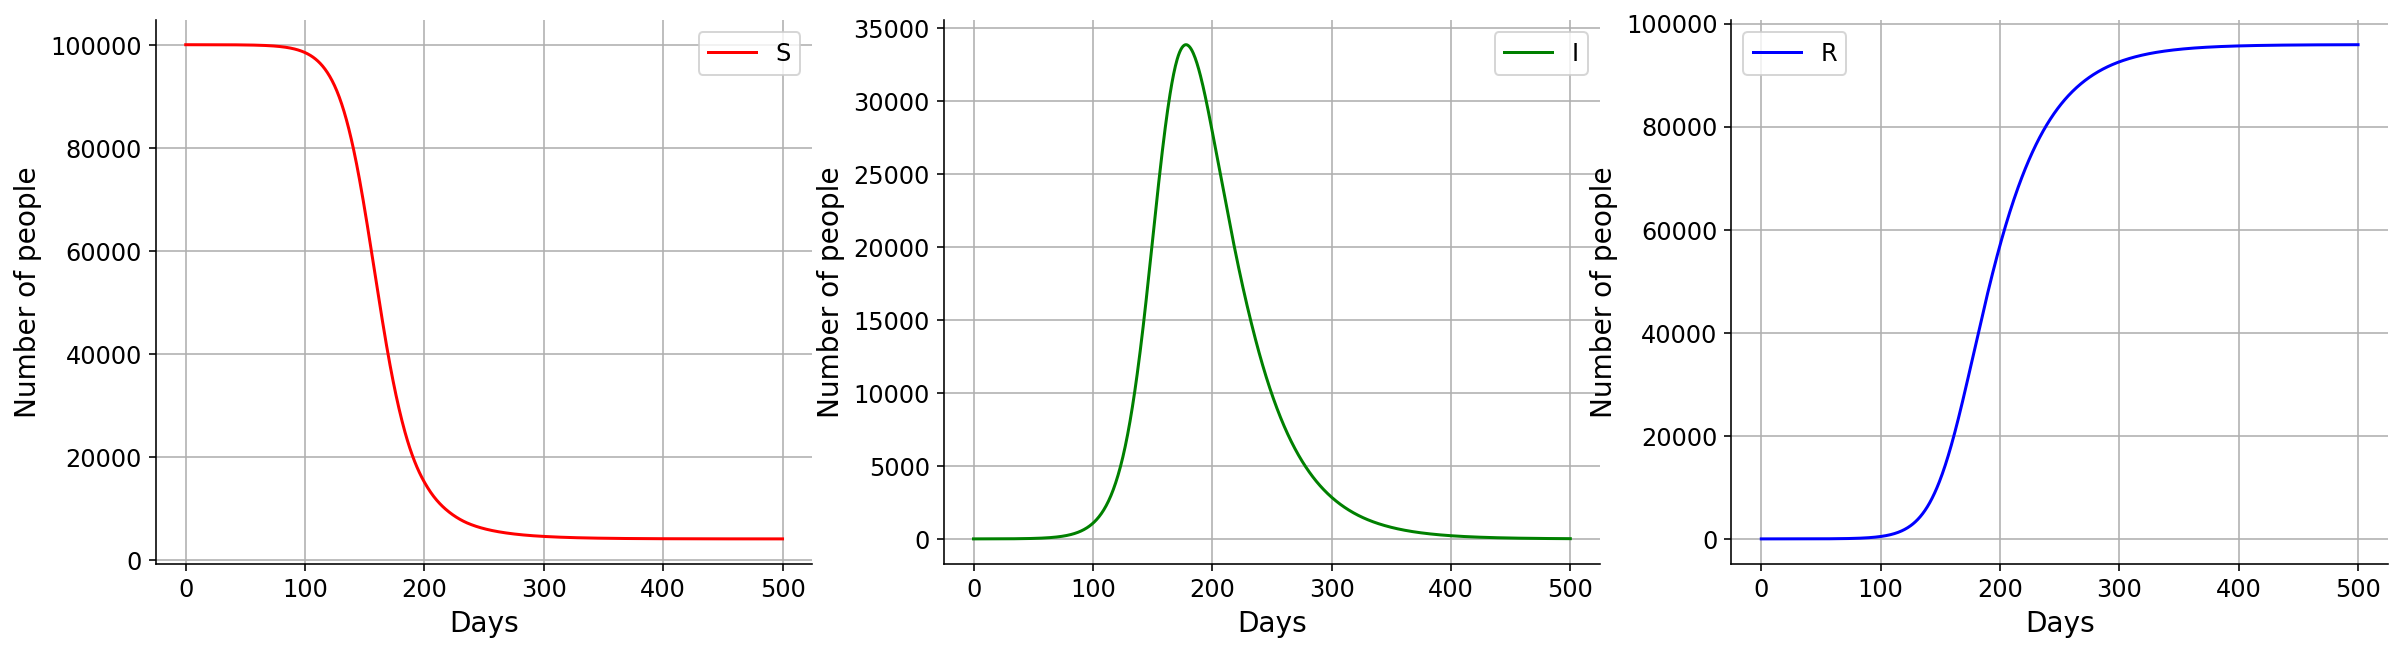

In [6]:
# OPTIONAL to get the same colors for S, I, R plots over all the notebook, we can define a dictionary of colors
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(t_range,S,label='S',c='red')
ax[1].plot(t_range,I,label='I',c='green')
ax[2].plot(t_range,R,label='R',c='blue')

for ax in ax.flat:
    ax.grid()
    ax.set_xlabel("Days")
    ax.set_ylabel("Number of people")
    ax.legend()

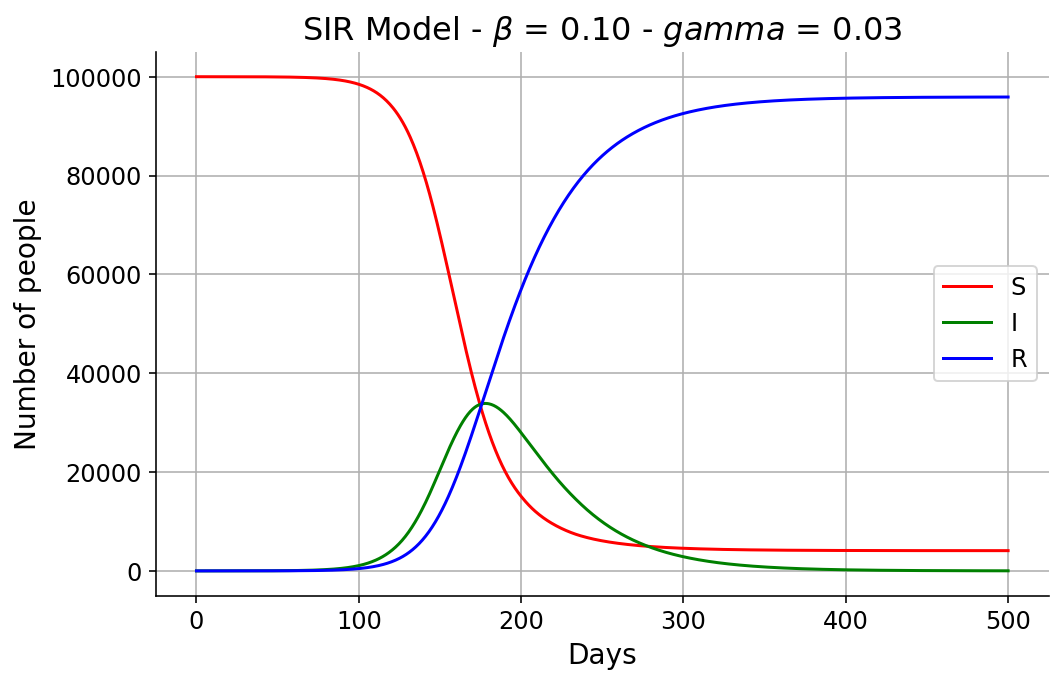

In [7]:
fig = plt.figure(figsize=(8,5))

plt.plot(t_range,S,label='S',c='red')
plt.plot(t_range,I,label='I',c='green')
plt.plot(t_range,R,label='R',c='blue')
#"T={:.2f}".format(Ts[i])
plt.title(r"SIR Model - $\beta$ = {:.2f} - $gamma$ = {:.2f}".format(beta, gamma))
plt.xlabel("Days")
plt.ylabel("Number of people")

plt.legend()
plt.grid()
plt.show()

Nel modello SIR fully mixed si riconoscono tre curve distine. La prima curva in rosso rappresenta il numero di persone sucettibili all'infezione al variare dei giorni. La curva verde rappresenta il numero di persone infette al variare dei giorni, e da ultimo la curva blu rappresenta il numero delle persone rimosse dal modello al variare dei giorni di evoluzione della pandemia. Dal grafico ottenuto tramite risoluzione dell'equazione differenziale posso riconoscere alcuni comportamenti.

1. Innanzitutto posso vedere come la curva dei suscettibili ha una lenta decrescita iniziale. Questo comportamento è dovuto al fatto che all'inizio della pandemia si ha un'unica persona infetta e il numero iniziale di infetti è statisticamente non rilevante su una popolazione che può contare 100 mila persone: domineranno le persone che non hanno ancora contratto la malattia. 

2. Successivamente, quando il numero di infetti cresce il numero di persone suscettibili subisce una forte diminuzione: ogni volta che una persona contrae la malattia passa da uno stato "S" a uno stato "I". Almeno all'inizio, tanto più infetti si hanno tanto più velocemente diminuirà il numero di suscettibili: più infetti significa più persone che in un giorno possono contrarre la malattia.

3. Il motivo per cui nel punto 2 ho scritto "almeno all'inizio" si riferisce al fatto che l'incremento degli infetti da parte dei suscettibili non è l'unico contributo alla curva che rappresenta il numero totale degli infetti. Come si può anche vedere dalle equazioni differenziali che definiscono il modello SIR, ogni infetto ha una probabilità non nulla di essere rimosso dal modello (guarigione o morte). Pertanto, sebbene con una probabilità inferiore alla probabilità di contagio, a ogni giorno dell'evoluzione della pandemia ogni infetto ha una probabilità di cambaire stato da "I" a "R": tanto più infetti ci sono, tanto più probabilità ho di aumento di persone nello stato R.

Riassumendo, le ragioni date nel punto 2 e nel punto 3 si contrastano vicendevolmente: se da una parte tanti più infetti ho, tanto più tende ad aumentare il numero di infetti, dall'altra parte tanti più infetti ho tanto più tende ad aumentare il numero delle persone rimosse, diminuendo così il numero degli infetti. All'inizio della pandemia, quando si ha un gran numero di infetti, domina il primo comportamento descritto. Ma, col decrescere del numero dei suscettibili nel modello, tenderà a diminuire il numero di infetti per il secondo comportamento descritto. Questo produce questa forma "a campana" della curva degli infetti che si può osservare nel grafico sopra riportato.

### SIR model on a network
The ODE approximation of the SIR model is not very realistic because it assumes a fully mixed population.
The fact that we do not interact randomly with one another, but rather have complex social structures, schools, commuting etc is what makes the whole thing much more difficult.

To explorer the importance of the **contact network** for the spread of a disease, we will implement a simple discrete-time SIR model that runs on an arbitrary network or graph. To do so, we will define a class `SIRonGraph` that holds together the **graph** where the SIR model runs and the **methods** (aka functions) that implement the SIR dynamics.

We will use the `networkx` module, a well-known python library to work with networks data. To check if you have it installed in your computer, run

In [8]:
import networkx as nx

If you get a `ModuleNotFoundError`, that means that you need to install it before continuing. In most cases, simply opening a terminal and running

```bash
> pip install networkx
```

should work. Additional installation instructions can be found [here](https://networkx.org/documentation/stable/install.html).

Networkx provides you the `Graph` type, that is, a kind of variable that represents a graph or network. Let us try it:

In [9]:
G = nx.Graph()

Networks have nodes and edges. Let us add some. Here we use letters to label the nodes, but integers would work as well.

In [10]:
G.add_nodes_from(["A", "B", "C", "D"])

In [11]:
G.add_edges_from([("A", "B"), ("B", "C"), ("C", "A"), ("C", "D")])

Now we want to have a look at our network. Networkx gives us some handy functions!

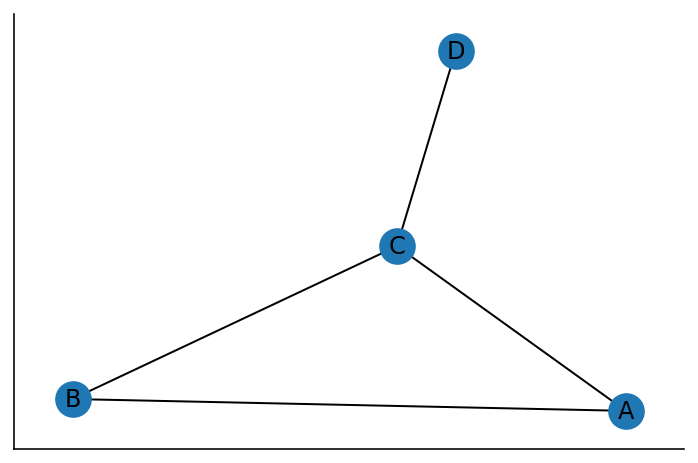

In [12]:
nx.draw_networkx(G)

Finally, networks can also hold some data on their nodes on edges. These are called **attributes** and are very useful. Let us create one:

In [13]:
initial_status = {
    "A": "S",
    "B": "S",
    "C": "I",
    "D": "S"
}

In [14]:
nx.set_node_attributes(G, initial_status, name="kind")

Now G carries the attribute *kind* with it. We can get the values of attributes of individual nodes easily:

In [15]:
G.nodes["C"]["kind"]

'I'

We can also modify the value of an attribute. Let us suppose node C infects node B. The we could do:

In [16]:
G.nodes["B"]["kind"] = "I"

If we need to get the attribute of all nodes, we can do it at once as follows:

In [17]:
current_status = nx.get_node_attributes(G, "kind")

In [18]:
current_status

{'A': 'S', 'B': 'I', 'C': 'I', 'D': 'S'}

### The SIR model as a python class

We will now create a class `SIRonGraph` to represent a SIR model on an arbitrary network. A class holds together data and functions (callled methods), and is exactly what we need in this case: a network and some functions that implement the SIR dynamics on it.

Classes can be a bit confusing at the beginning, but all you need to understand is that `self` means literary 'myself', that is, methods (functions) get as first argument the object they are acting on. This means that we can "store" a variable in one method and "retrieve" it in another! No need to pass it around!

Look at the following example code and play with it to make sure you understand how `self` works.

In [19]:
class Model:
    # this is a special method that gets called when you create an instance of your class
    def __init__(self, name):
        self.name = name
    
    def set_x(self, x):
        self.x = x
        
    def increment_x(self):
        self.x += 1

    def show_x(self):
        return self.x
    

In [20]:
model1 = Model(name="my first model")
model2 = Model(name="another model")

In [21]:
model1.set_x(3)
model2.set_x(-2)

In [22]:
model1.increment_x()

In [23]:
model1.show_x()

4

In [24]:
model2.show_x()

-2

We can also access information stored in our objects. Notice that our models had a name that was set at initialization.

In [25]:
model1.name

'my first model'

So, let us go back to our SIR model. The input to create a new SIR model on an arbitrary network is the following:

1. The graph onto which we want to run the SIR model.
2. A list of initially infected nodes.
3. The coefficient $\beta$
4. The coefficient $\gamma$

So, we create a class `SIRonGraph` that, when initialized, simply stores the input.

In [26]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network. 
        """
        # store parameters
        self.beta = beta
        self.gamma = gamma
        self.network = network


Let us try it. First we need to create a graph! Networkx has some functions to generate standard graphs. We could start with a lattice graph, for instance.

In [27]:
# 2 rows, 3 columns
G = nx.hexagonal_lattice_graph(2, 3)

Notice that nodes are labelled with a tuple of integers `(col, row)` and that `G` comes with a nice `pos` node attribute, which we can use to nicely plot the network.

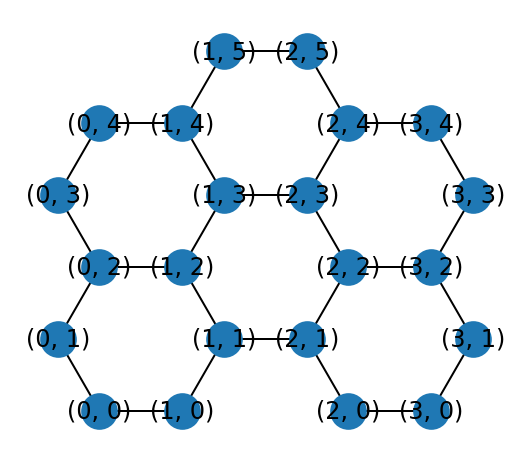

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_aspect(1)
ax.set_axis_off()

pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos)

Now we can create our first model

In [29]:
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(5, 3)])

Notice that you can retrieve all the information that is stored in `self`. 

In [30]:
model.network

Notice that `model.network` is not a copy of `G`: it is exactly the same object, point to the same memory address!

In [31]:
G

In [32]:
model.beta

0.3

In [33]:
model.gamma

0.1

### Exercise 5.3
Our model should do a few more things at initialization:
1. Checking that $\beta$ and $\gamma$ have sensible values.
2. Making sure that all elements in input list of inital infected are really nodes of the network.
2. Creating a node attribute called "kind" with value "S" for all nodes except for those in the list of `inital_infected`

Extend the SIRonGraph code below and implement points 1 and 2 in the ``__init__`` method.

In [34]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        
        # make sure node in initial_infected list are really nodes of the network.
        for i,item in enumerate(initial_infected):
            assert initial_infected[i] in G.nodes, "Your initial infect is not in an existing node"
            
        # set initial status of nodes as node att
        nx.set_node_attributes(G, "S", name="kind")
        for i,item in enumerate(initial_infected):
            G.nodes[initial_infected[i]]["kind"] = "I"
        

        # make sure params make sense 
        assert beta<=1, "It's better to give beta parameter in range [0,1]"
        assert gamma<=1, "It's better to give gamma parameter in range [0,1]"
        assert beta>0, "Beta's negative value doesn't make sense"
        assert gamma>0, "Gamma's negative value 1 doesn't make sense"
        
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected
    
    

### Exercise 5.4
1. Create a function to visualize a hexagonal lattice model, with nodes colored by type. Your function should take as input the model instance (object of kind SIRonGraph) and display the network, coloring S, I and R nodes with different colors.
2. Show that your function works for a few examples with different input graph sizes and different sets of initially infected nodes.

**Tip**: look into the networkx documentation! It is [here](https://networkx.org/documentation/stable/reference/drawing.html).

In [35]:
def show_hex_model(model, ax=None):
    # creates a figure if no axis was passed
    ax_was_none = ax is None
    if ax_was_none:
        # create a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_aspect(1)
        ax.set_axis_off()
        
        
    # get the positions and kind of nodes
    pos = nx.get_node_attributes(G, 'pos')
    kinds = nx.get_node_attributes(G,'kind')

    # prepare a list of colors for the nodes using the kinds dict
    node_color = ["blue", "red", "green"]

    # draw the network
    color_map=[]
    for node in G:
        if kinds[node]=="I":
            color_map.append(node_color[1])
        if kinds[node]=="S":
            color_map.append(node_color[0])
        if kinds[node]=="R":
            color_map.append(node_color[2])
    ax.set_aspect(1)
    ax.set_axis_off()
    graph = nx.draw_networkx(G,pos, node_color=color_map, ax=ax) # node lables

    
    # returns the new figure if it was created here
    if ax_was_none:
        return fig, ax

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

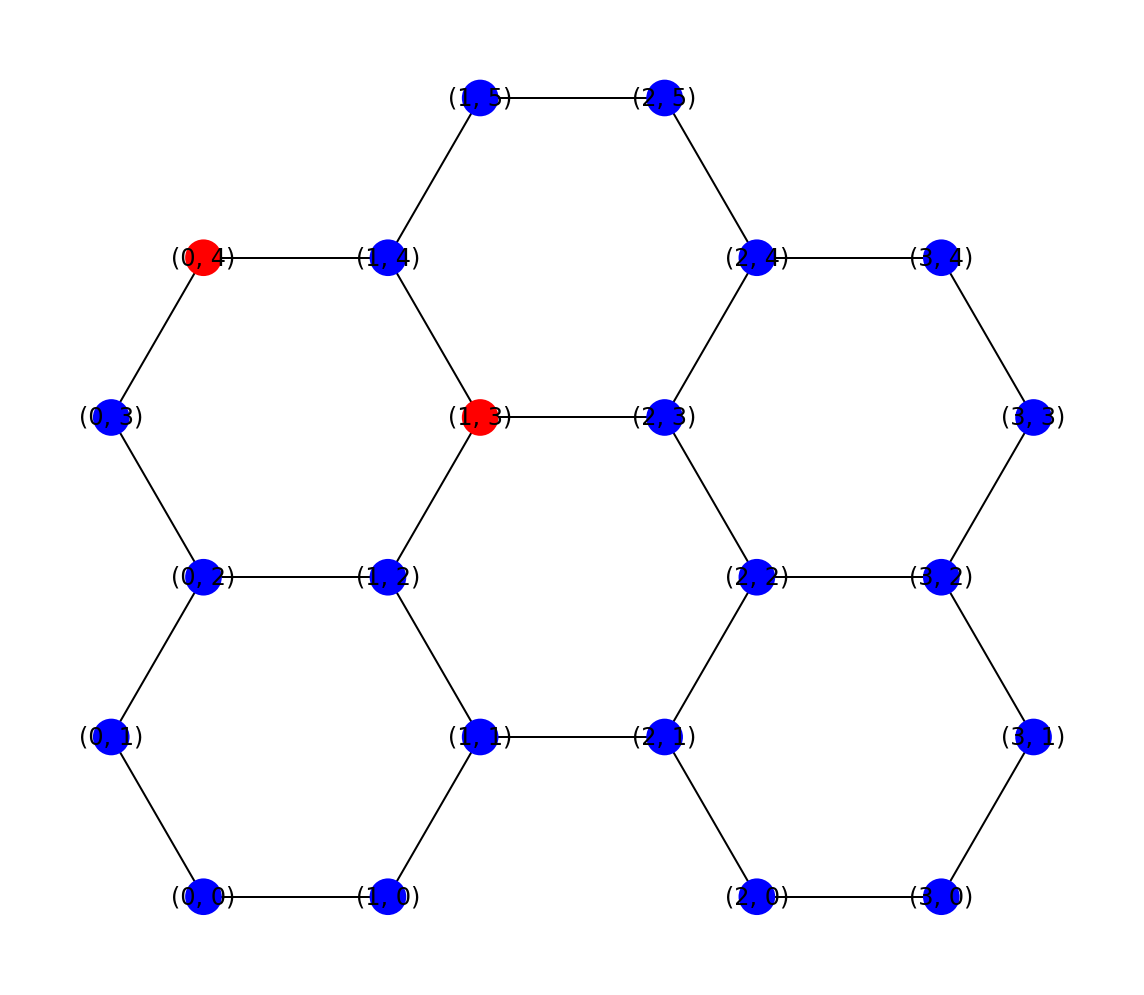

In [36]:
model=SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3), (0,4)])
show_hex_model(model)

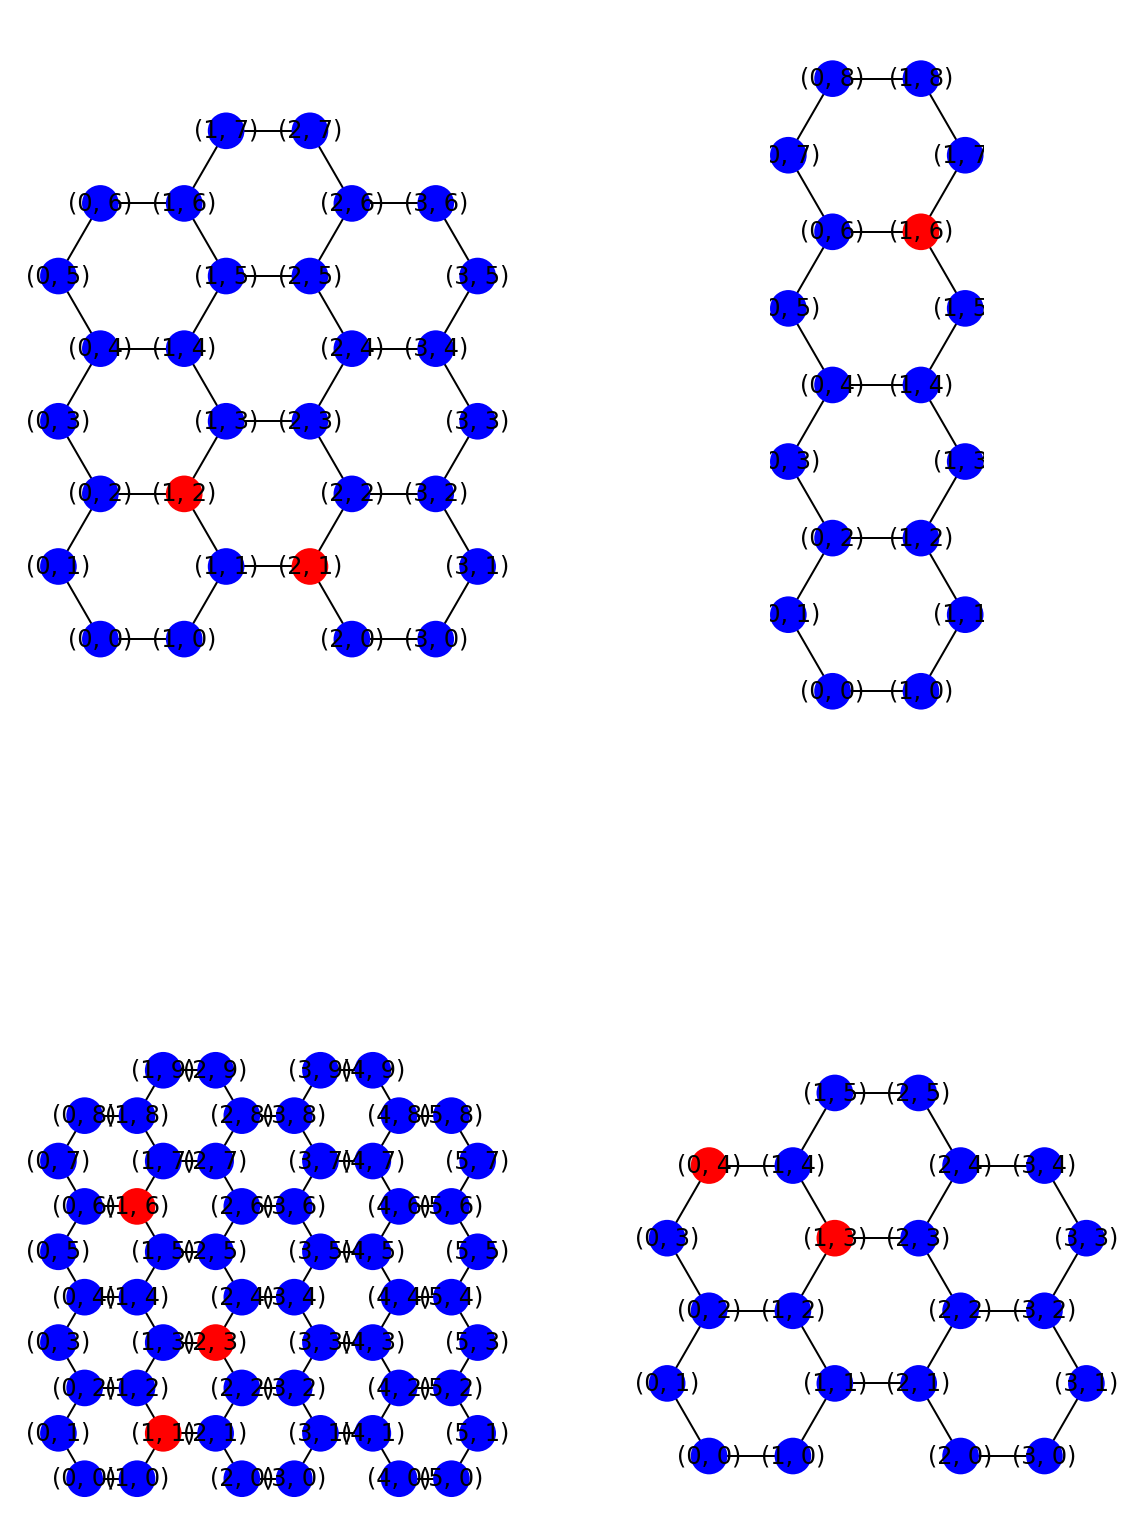

In [37]:
fig, axx = plt.subplots(2, 2, figsize=(10, 15))
axx = axx.reshape(-1)

G = nx.hexagonal_lattice_graph(3, 3)
model=SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 2), (2,1)])
show_hex_model(model, ax=axx[0])

G = nx.hexagonal_lattice_graph(4, 1)
model=SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 6)])
show_hex_model(model, ax=axx[1])


G = nx.hexagonal_lattice_graph(4, 5)
model=SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 6), (2,3), (1,1)])
show_hex_model(model, ax=axx[2])

G = nx.hexagonal_lattice_graph(2, 3)
model=SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3), (0,4)])
show_hex_model(model, ax=axx[3])


La mia classe di inizializzazione funziona correttamente per diverse dimensioni del network e diversi infetti inizializzati.

### SIR dynamics as class methods
Now we want to be able to run the SIR dynamics on our `SIRonGraph` objects. To simplify things, we  consider **discrete time** simulation, so that at each time-step:
+ Infected individuals have a chance to recover, and they do so with probability $\gamma$.
+ Susceptible individuals can be infected by any of the infected individuals to which they are connected. This happens with probability $\beta$ for each S-I edge.

### Exercise 5.5
Implement the dynamics of the SIR model as methods of your `SIRonGraph` class. You might want to implement two methods separately, as follows:

+ `_step(self)`: this method implements one single time-step, as descrived above.
+ `run(self, num_timesteps: int)`: this method (for now) simply calls `_step` repeatedly.

You will see, in a while, that it is useful to organize things as we are doing.

In [38]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        
        # make sure node in initial_infected list are really nodes of the network.
        for i,item in enumerate(initial_infected):
            assert initial_infected[i] in network.nodes, "Your initial infect is not in an existing node"
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for i,item in enumerate(initial_infected):
            network.nodes[initial_infected[i]]["kind"] = "I"
        

        # make sure params make sense 
        assert beta<=1, "It's better to give beta parameter in range [0,1]"
        assert gamma<=1, "It's better to give gamma parameter in range [0,1]"
        assert beta>=0, "Beta's negative value doesn't make sense"
        assert gamma>=0, "Gamma's negative value 1 doesn't make sense"
        
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected
    
        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        i=0
        for i in range(num_timesteps):
            self._step()
        
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                p = random.uniform(0, 1)
                if p<self.gamma:
                    self.network.nodes[node]["kind"] = "R"
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        temp_set=set()
        
        for edge in self.network.edges:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                temp_set.add(tuple(edge))
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                temp_set.add(tuple(edge))
        
        
        for edge in temp_set:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[1]]["kind"] = "I"
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[0]]["kind"] = "I"


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

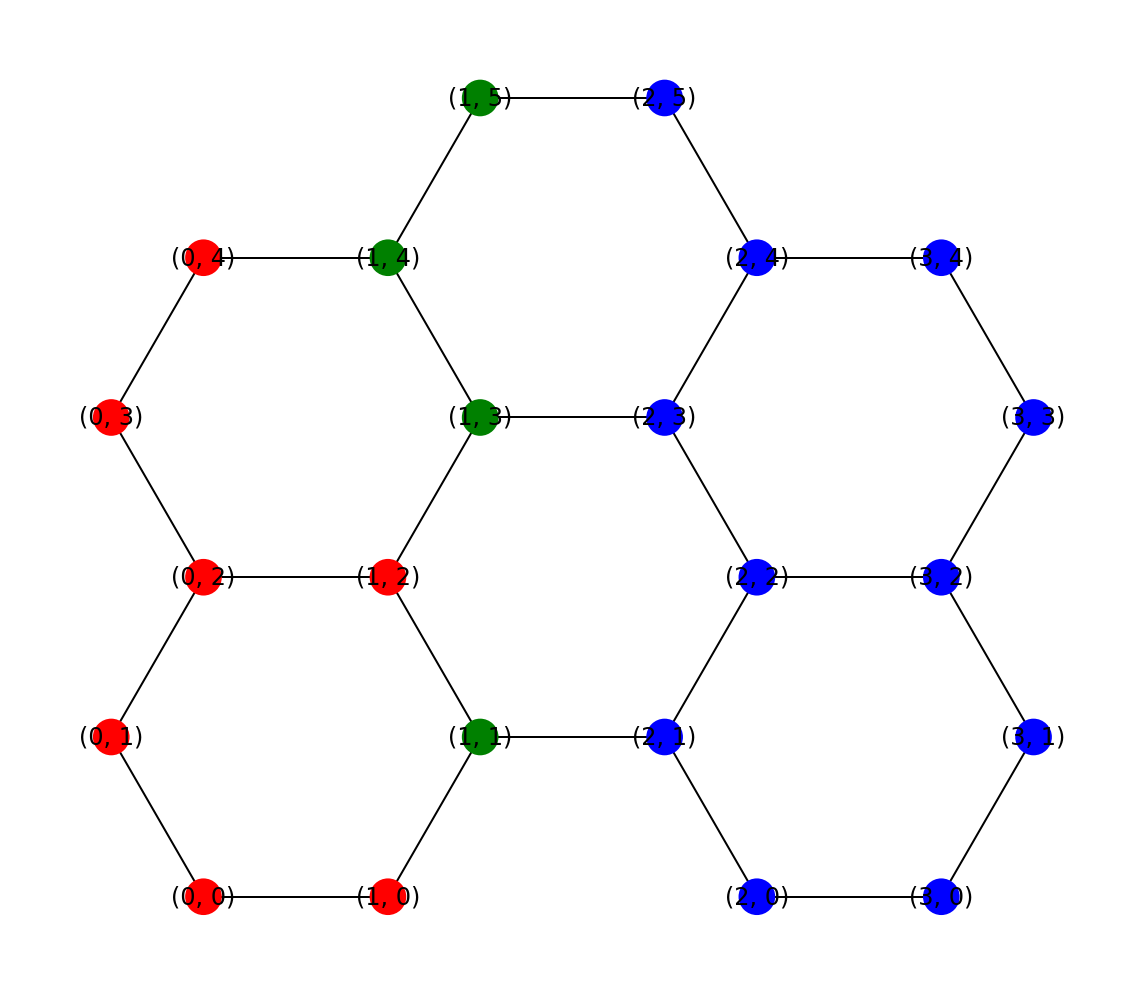

In [39]:
model=SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3), (0,4)])
#model=SIRonGraph(network=G, beta=1, gamma=0.0, initial_infected=[(1, 3), (0,4)])
model.run(10)
show_hex_model(model)

### Exercise 5.6
Use your visualization function to show the evolution of a SIR model running in a hex lattice. You should decide the system size, number of timesteps and other parameterrs wisely to show that your code works properly.

In [40]:
G = nx.hexagonal_lattice_graph(10, 10)
model = SIRonGraph(network=G, initial_infected=[(5, 5)], beta=0.3, gamma=0.05)

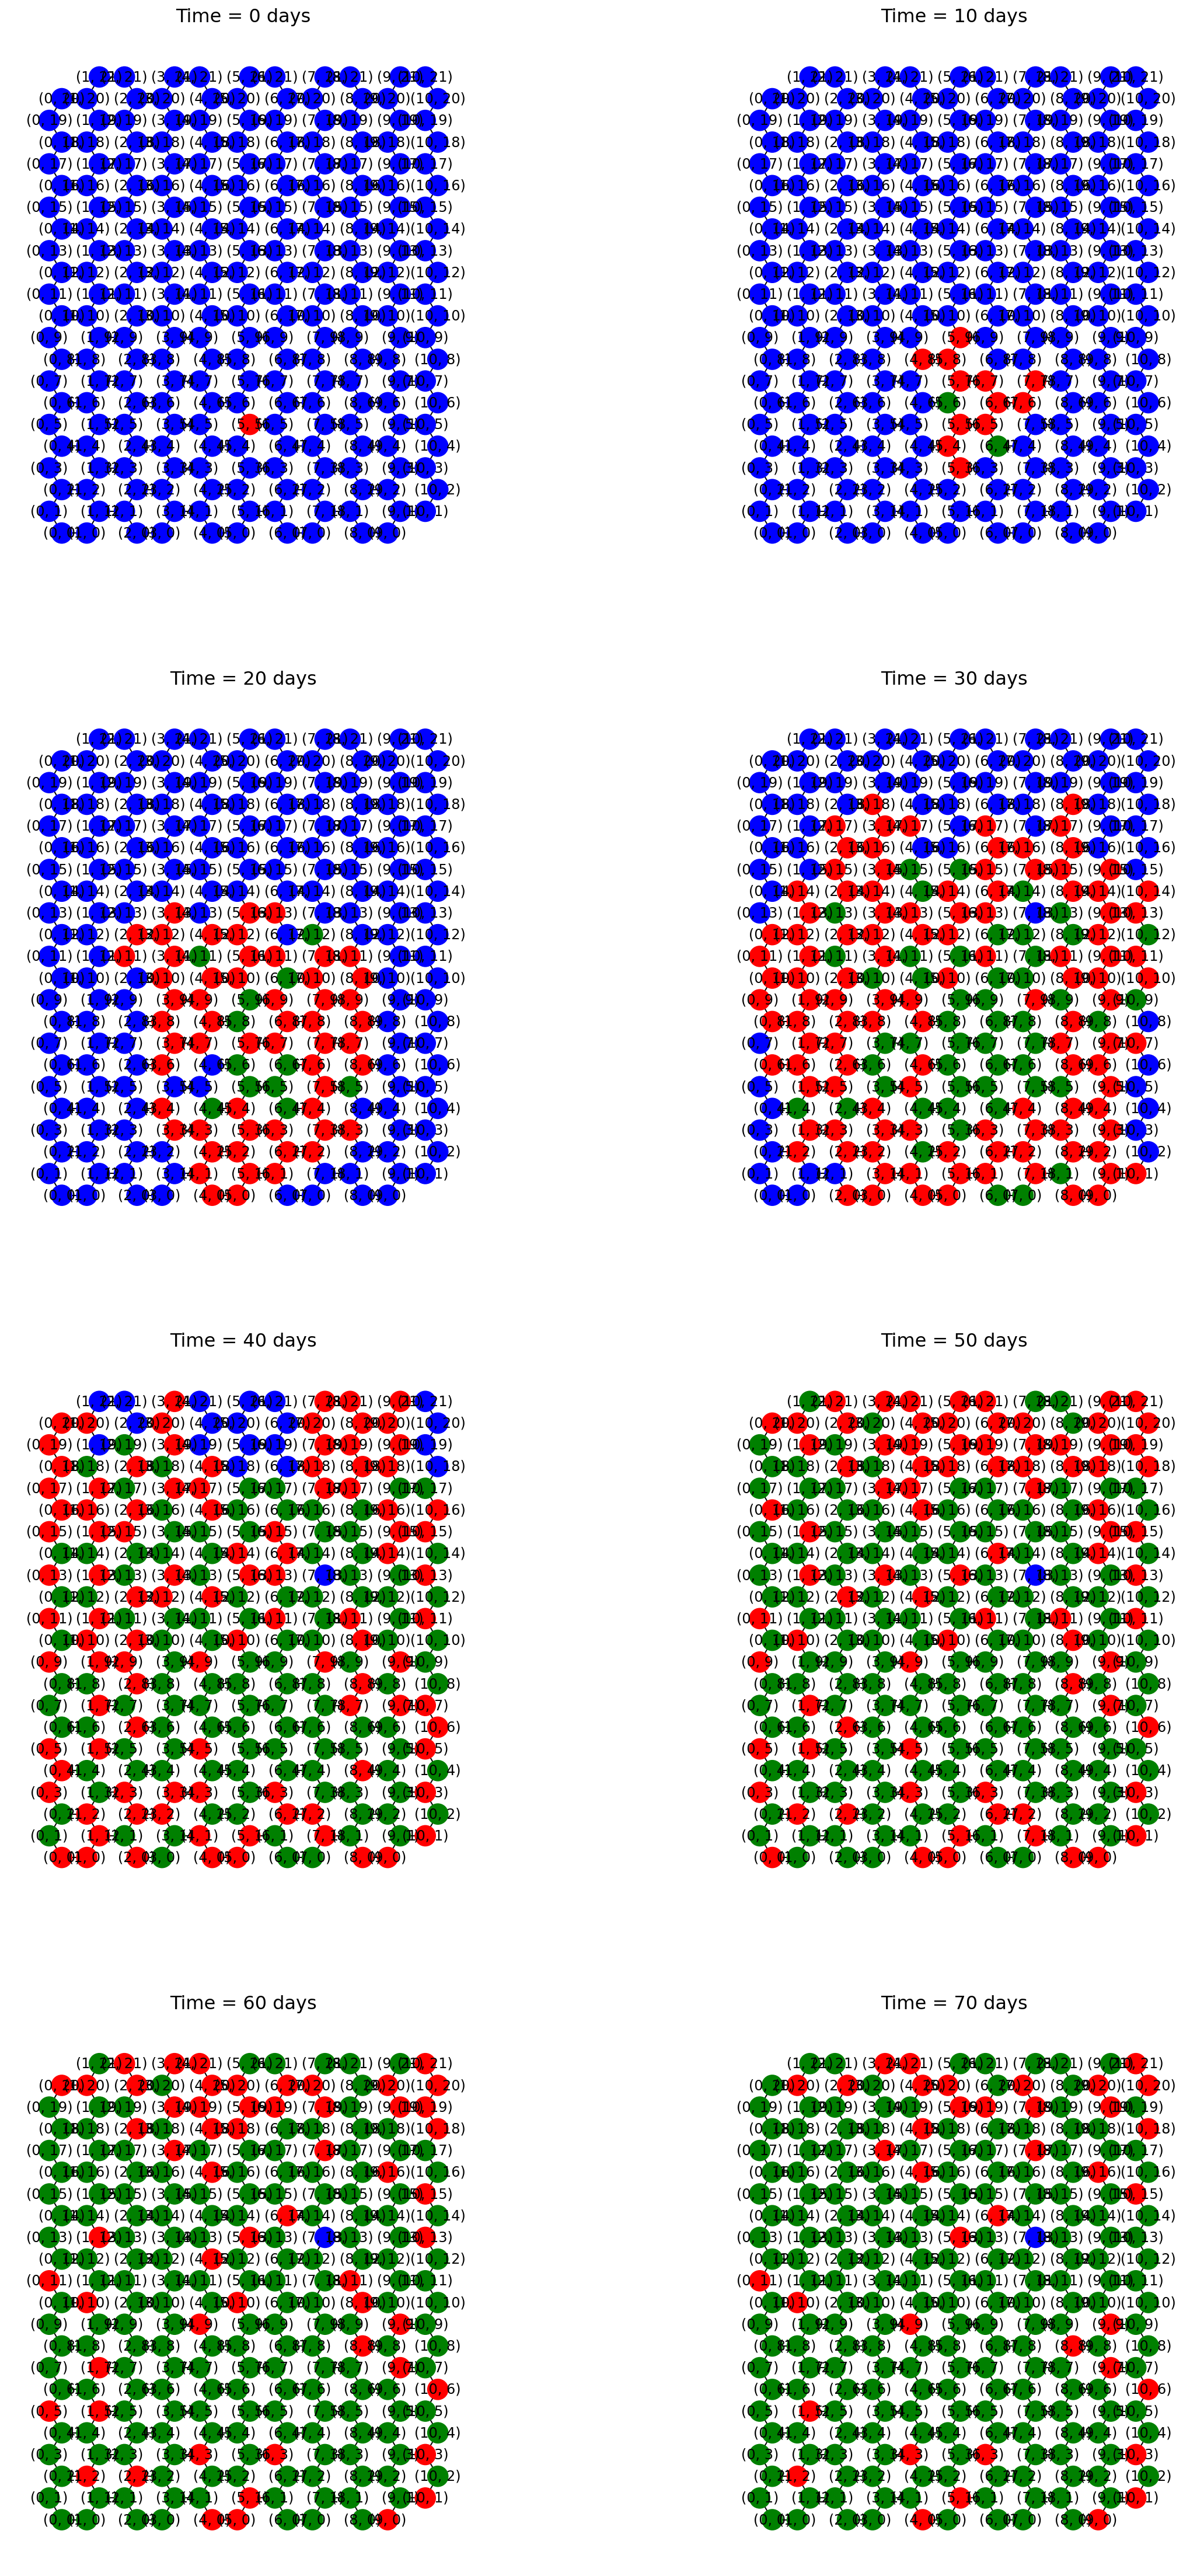

In [41]:
fig, axx = plt.subplots(4, 2, figsize=(20, 40))
axx = axx.reshape(-1)


for i,ax in enumerate(axx):
    
    ax.set_title("Time = {:.0f} days".format(10*i))
    show_hex_model(model,ax = ax)
    model.run(10)

### Storing SIR evolution as a class attribute
Now our class can run the SIR dynamics, but it doesn't "remember" the whole evolution of the simulation: only the final state is available. One way of storing some quantities of interest during the simulation is as follows:

1. Create an empty list at initialization.
```python
class SIRonGraph:
     def __init__(self, G: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
         ...
         # empty list, we will add info durring the simulation
         self.history = []
         ...
```

2. Create a _log() method that, when called, computes the information we want to store and adds it to the self.history list.

```python
   def _log(self):
        # do computations
        var1 = ...
        var2 = ...
        ...
        
        # create a block of info as list
        info = [var1, var2, ...]
        # or as a dict
        info = {
            "var1": var1,
            "var2": var2,
            ...
        }
        # or using any other scheme you like
        info = ...
        
        # add the info block to the history log
        self.history.append(info)
```

3. Call the ._log() method every time you want to store the variables of interest. That could be at every timestep or once in a while only. 
It is also wise to call `._log()` once at initialization, to store the initial status. 
```python
   def __init__(self, ...):
         ...
         self._log()
        
   def run(self, num_timesteps: int):
         """Run the SIR dynamics for some time."""
         ...
         for _ in range(num_timesteps):
              self._step()
              self._log()
         ...
```

### Exercise 5.7
1. Modify your SIRonGraph class so that it stores the number of **S**, **I** and **R** individuals at each timestep.
2. Simulate the SIR model in a network of your choice, and plot the evolution of the system (S, I, R) over time. Try to choose the parameters wisely, so that a typical epidemic wave can be seen.

In [42]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        
                # make sure node in initial_infected list are really nodes of the network.
        for i,item in enumerate(initial_infected):
            assert initial_infected[i] in network.nodes, "Your initial infect is not in an existing node"
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for i,item in enumerate(initial_infected):
            network.nodes[initial_infected[i]]["kind"] = "I"
        

        # make sure params make sense 
        assert beta<=1, "It's better to give beta parameter in range [0,1]"
        assert gamma<=1, "It's better to give gamma parameter in range [0,1]"
        assert beta>=0, "Beta's negative value doesn't make sense"
        assert gamma>=0, "Gamma's negative value 1 doesn't make sense"
        
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected
        
    
        # create empty list to store history        
        self.history=[]
        # store info of initial condition
        self._log()
        
        
    def run(self, num_timesteps: int):
        # modify your previous code!
        """Run SIR dynamics for num_timsteps steps"""
        i=0
        for i in range(num_timesteps):
            self._step()
            self._log()
    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                p = random.uniform(0, 1)
                if p<self.gamma:
                #if p< random.uniform(0,2*self.gamma)
                    self.network.nodes[node]["kind"] = "R"
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        temp_set=set()
        
        for edge in self.network.edges:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                temp_set.add(tuple(edge))
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                temp_set.add(tuple(edge))
        
        
        for edge in temp_set:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[1]]["kind"] = "I"
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[0]]["kind"] = "I"

    def _log(self):
        # do computations. Devi solo trovare il modo di contare il numero di S, di I e di R
        num_S = 0
        num_I = 0
        num_R = 0
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                num_S += 1
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                num_I += 1
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "R":
                num_R += 1
        
        # create a block of info as list
        info = [num_S, num_I, num_R]

        # add the info block to the history log
        self.history.append(info)
                

In [43]:
# create the model
beta=0.3
gamma=0.03
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=beta,
    gamma=gamma
)

In [44]:
# run the model for some time
model.run(500)

In [45]:
S=[]
I=[]
R=[]
for i in range(len(model.history)):
    S.append(model.history[i][0])
    I.append(model.history[i][1])
    R.append(model.history[i][2])
my_t = np.linspace(0, len(S), num=len(S))

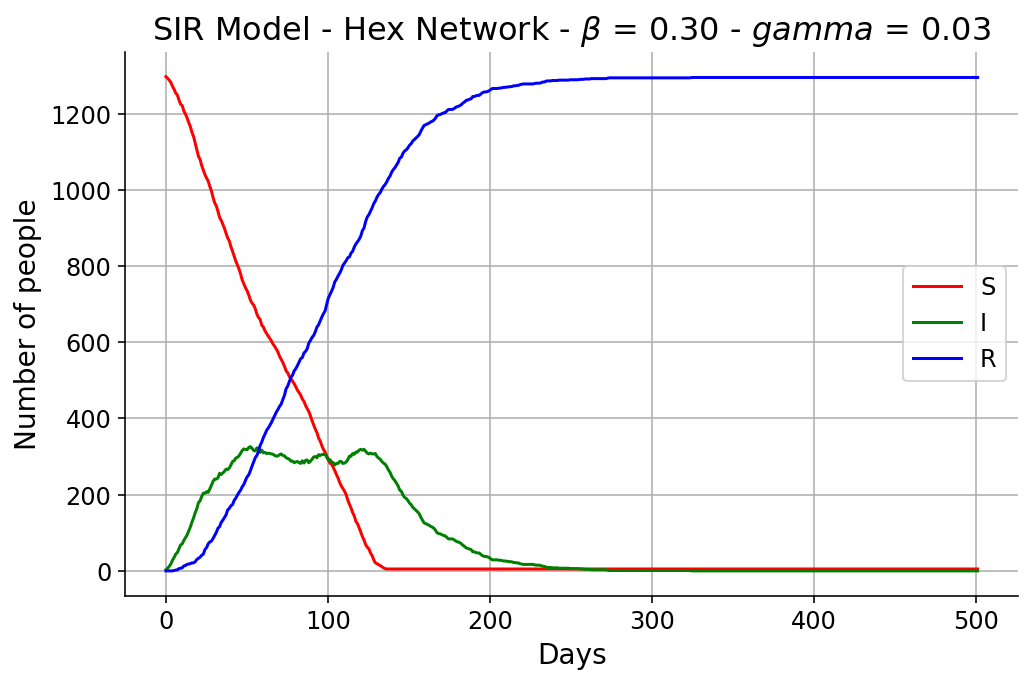

In [46]:
# plot S,I,R vs time
fig = plt.figure(figsize=(8,5))

plt.plot(my_t,S,label='S',c='red')
plt.plot(my_t,I,label='I',c='green')
plt.plot(my_t,R,label='R',c='blue')
plt.title(r"SIR Model - Hex Network - $\beta$ = {:.2f} - $gamma$ = {:.2f}".format(beta, gamma))
plt.xlabel("Days")
plt.ylabel("Number of people")

plt.legend()
plt.grid()
plt.show()

### Exercise 5.8
Which kind of network could give results equivalent to the ODE solution of the first part of the notebook? Explain why.

Per ottenere un network che dia dei risultati equivalenti a quelli ottenuti risolvendo el equazioni differenziali del modello SIR, mi vengono in mente due possibili risposte, una banale e una non banale:

1. La risposta banale è quella di avere un "Fully connected network" in cui ciascuno dei nodi (rappresentativo della persona) è in contatto con tutti i restanti nodi del network. In questo modo ci si rimette nell'ipotesi iniziale di popolazione "Fully mixed" e pertanto, a meno di fluttuazioni statistiche dovute al processo stocastico di estrazione all'interno della classe, posso ottenere gli stessi risultati ottenuti all'inizio dell'esercitazione.

2. Un secondo network per ottenere risultati equivalenti a quelli ottenuti risolvendo le equazioni differenziali del modello SIR, può essere lo "small-world-network". In questo tipo di network, i nodi non vengono disposti "in serie", ma i nodi vicini a un qualunque nodo dato, possono essere vicini a un qualunque altro nodo random del network con con una certa probabilità. Si creano quindi dei ponti a lungo range tra nodi che precedentemente avremmo trovato distanti nel network. In tal modo si possono creare diversi centri di infezione da cui la pandemia può evolvere, e con ulteriori punti a lungo range creare nuovi centri. Questo è un network che potrebbe più verosimilmente rappresentare una popolaizone "Fully mixed" senza avere però un network in cui i nodi sono tutti a contatto tra loro.

### Exercise 5.9
Compare the ODE solution with simulation results on the appropiate network. Do you see differences? If so, explain why.
Remember to properly add labels and legends to all your plots!

In [47]:
beta=0.3
gamma=0.03
# define your model
model = SIRonGraph(
    network=nx.newman_watts_strogatz_graph(n=1000,k=4,p=0.25),
    beta=beta,
    gamma=gamma,
    initial_infected=[np.random.randint(1,99)]
)
model.run(500)
S=[]
I=[]
R=[]
for i in range(len(model.history)):
    S.append(model.history[i][0])
    I.append(model.history[i][1])
    R.append(model.history[i][2])
my_t = np.linspace(0, len(S), num=len(S))

In [48]:
# run the model, extract results
y0 = (S[0], I[0], R[0])
tmax = 500
my_t_eval = np.linspace(0, tmax, num=1000)
ode_result = solve_ivp(odes_SIR, [0,tmax], y0, t_eval = my_t_eval)
assert ode_result.success
t_range = ode_result.t
S_solve, I_solve, R_solve = ode_result.y

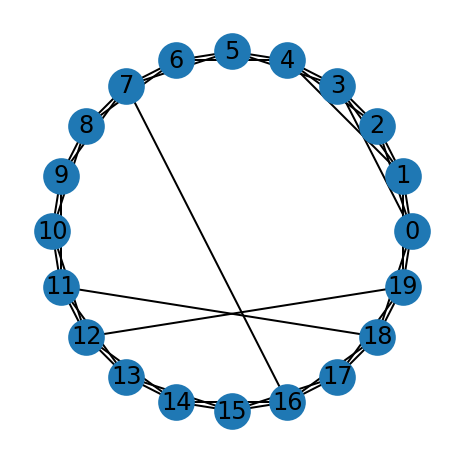

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_aspect(1)
ax.set_axis_off()

G=nx.newman_watts_strogatz_graph(n=20,k=4,p=0.25)
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos)

Questa è un'immagine del mio Network. Come si può vedere i nodi sono in serie l'uno con l'altro con alcuni che presentano delle connessioni a lungo range con nodi non consecutivi. Questo è lo "Small-World Newtork" descritto prima.

In [50]:
from tqdm import tqdm

# optional: maybe more than one simulation and then average?
simulation_number=5

for i in tqdm(range(simulation_number)):
    model = SIRonGraph(
        network=nx.newman_watts_strogatz_graph(n=1000,k=4,p=0.25),
        beta=beta,
        gamma=gamma,
        initial_infected=[np.random.randint(1,99)]
    )
    model.run(500)
    for i in range(len(model.history)):
        S[i] += model.history[i][0]
        I[i] += model.history[i][1]
        R[i] += model.history[i][2]
for i in range(len(model.history)):
    S[i] /= (simulation_number+1)
    I[i] /= (simulation_number+1)
    R[i] /= (simulation_number+1)

100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.86s/it]


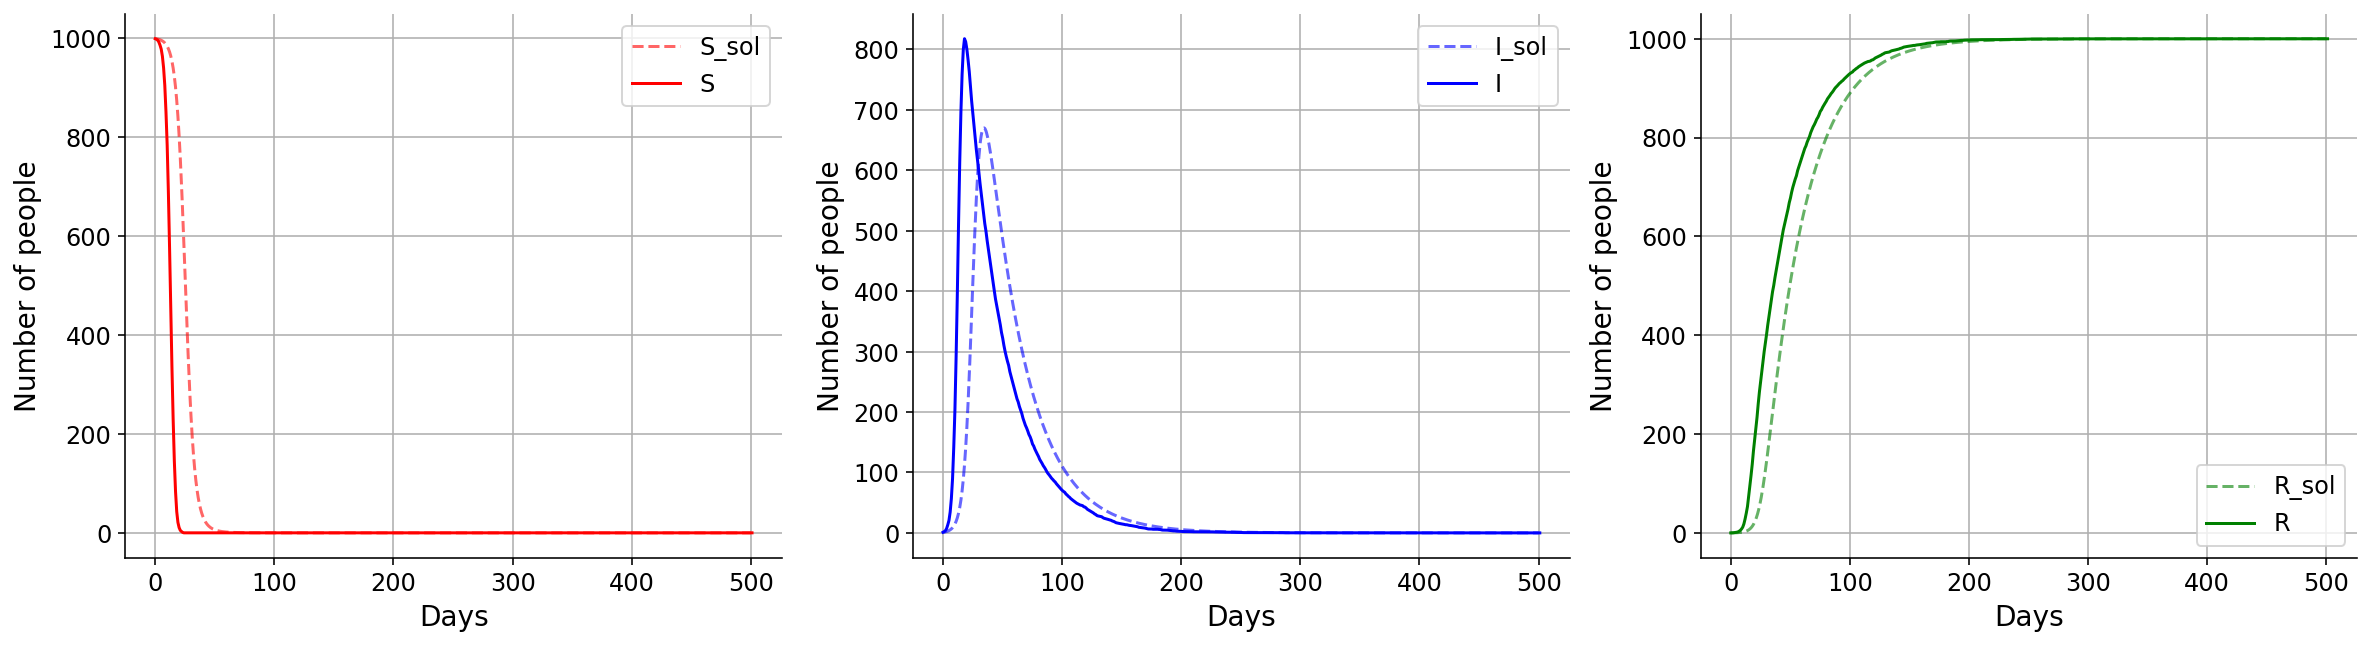

In [51]:
SIR_colors = {
    "S": "red",
    "I": "blue",
    "R": "green"
}

# plot results togetherr with old ODE results
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(t_range,S_solve,label='S_sol',c=SIR_colors["S"], linestyle="dashed", alpha=0.6)
ax[1].plot(t_range,I_solve,label='I_sol',c=SIR_colors["I"], linestyle="dashed", alpha=0.6)
ax[2].plot(t_range,R_solve,label='R_sol',c=SIR_colors["R"], linestyle="dashed", alpha=0.6)
ax[0].plot(my_t,S,label='S',c=SIR_colors["S"])
ax[1].plot(my_t,I,label='I',c=SIR_colors["I"])
ax[2].plot(my_t,R,label='R',c=SIR_colors["R"])

for ax in ax.flat:
    ax.grid()
    ax.legend()
    ax.set_xlabel("Days")
    ax.set_ylabel("Number of people")

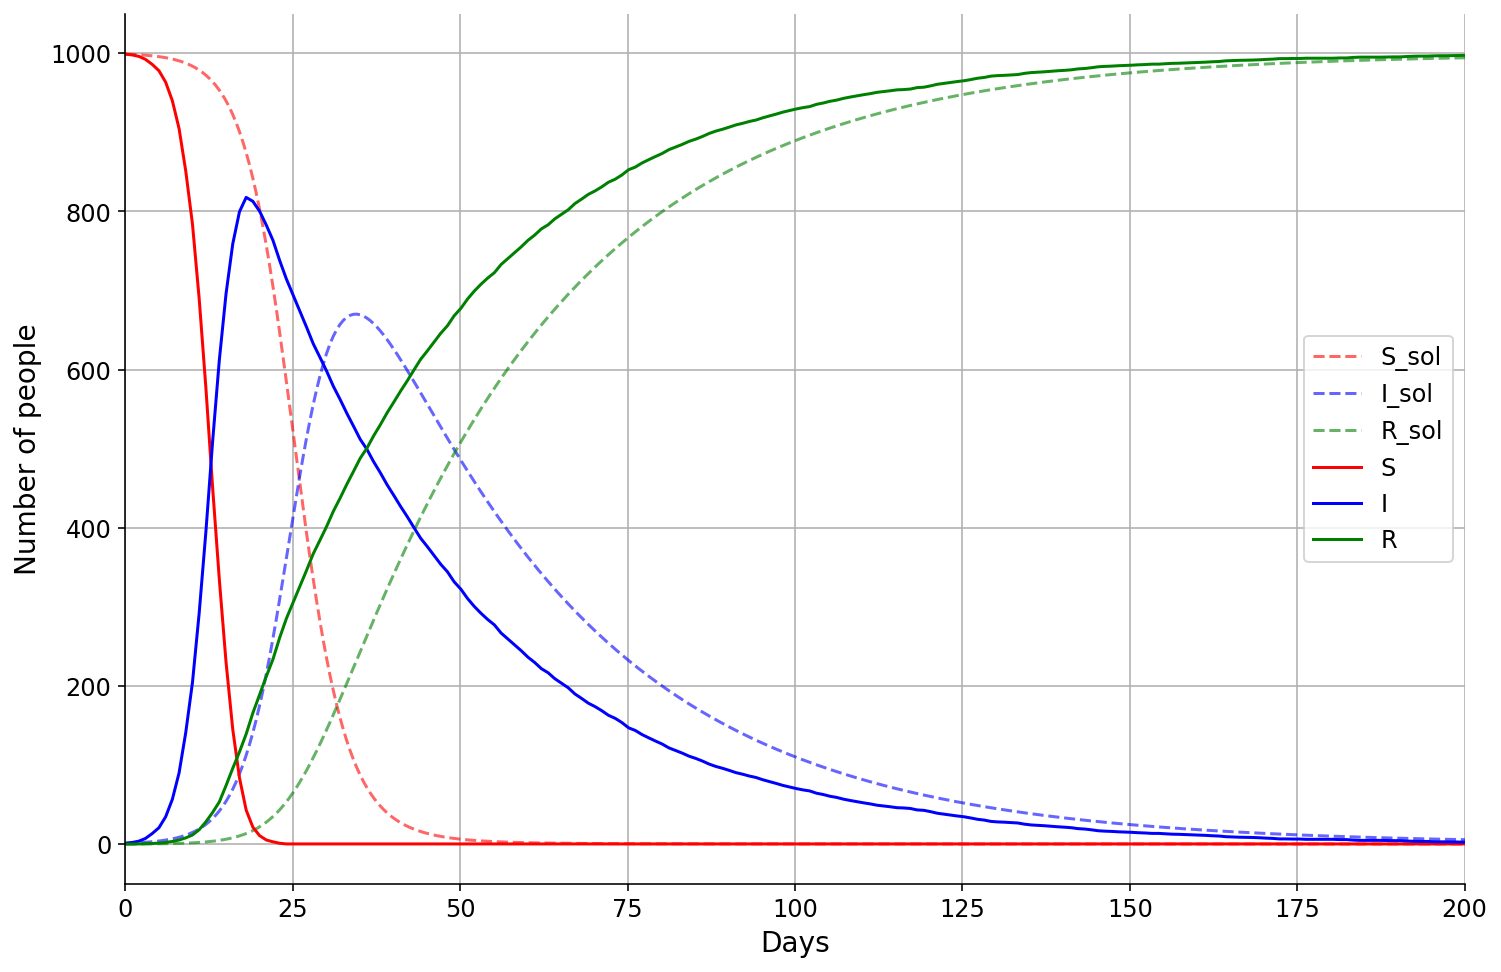

In [52]:
plt.figure(figsize=(12,8))

plt.plot(t_range,S_solve,label='S_sol',c=SIR_colors["S"], linestyle="dashed", alpha=0.6)
plt.plot(t_range,I_solve,label='I_sol',c=SIR_colors["I"], linestyle="dashed", alpha=0.6)
plt.plot(t_range,R_solve,label='R_sol',c=SIR_colors["R"], linestyle="dashed", alpha=0.6)
plt.plot(my_t,S,label='S',c=SIR_colors["S"])
plt.plot(my_t,I,label='I',c=SIR_colors["I"])
plt.plot(my_t,R,label='R',c=SIR_colors["R"])

plt.xlim([0, 200])
plt.legend()
plt.grid()
plt.xlabel("Days")
plt.ylabel("Number of people")
plt.show()

- Sicuramente, l'andamento delle curve che descrivono suscettibili, infetti e rimossi è molto più simile alle curve ottenute risolvendo le equazioni differenziali del modello rispetto ai risultati ottenuti nella simulazione su reticolo esagonale. Tuttavia, si possono distinguere ancora delle discrepanze. Queste sono principalmente dovute al fatto che i nodi nello small-world network non sono totalmente connessi come invece nel modello "fully connected" con cui si sta ipotizzando di risolvere le equazioni differenziali. Questo si può bene osservare nel comportamento della curva dei suscettibili a tempi molto grandi: in questo caso la curva non tende a zero ma a un certo valore finito. La ragione è che all'interno del reticolo possono trovaresi alcuni suscettibili che non sono raggiunti da alcuna connessione da qualche nodo infetto. Questo non vuol dire che gli infetti sono nulli nel reticolo (basti guardare quello che succede al giorno 100), ma vuol dire che non raggiungono i suscettibili rimasti con nessuna connesione, e piano piano tenderanno tutti a diventare nodi rimossi "R".

- Un secondo motivo per cui la simulazione ha certe differenze con la risoluzione delle equazioni differenziali è per il semplice fatto che la simulazione, in quanto simulazione Monte Carlo è stocastica: ha certe componenti randomiche al suo interno. La componente randomica in questo caso è l'estrazione del numero con cui si "decide" se una persona diventa infetta o rimossa. Questa componente stocastica non consentirà alla simulazione di essere in accordo senza errori con i risultati ottenuti risolvendo le equazioni differenziali.

## The spread of epidemic disease on networks
We will now follow some of the derivations in 

*Spread of epidemic disease on networks.*  
Newman, M.E.J. (2002).  
Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 66, 016128.  

You can get the preprint version of the paper, which is almost equal to the published verison, here:  
[https://arxiv.org/abs/cond-mat/0205009](https://arxiv.org/abs/cond-mat/0205009)  

Remember that the *transmissibility* $T$ is the average probability that a victim will infect each of their contacts.
In the paper, Newmann computes it as (Eq 6)
$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau
$$

### Exercise 5.10
Read the first part of the paper. Under which assumptions is the Eq. 6 valid? What is the meaning of $r$ and $\tau$ in the manuscript? Can you relate $P(r)$ and $P(\tau)$ to our coefficients $\beta$ and $\gamma$?

1. Si assume che il modello sia composto da tre classi S, I, R con un network dove può variare il numero di connessioni tra i diversi nodi.

2. Si assume che il rate $r_{ij}$, variabile per cui data una connesione $i-j$ (dove $i$ è il nodo infetto) si ha un'effettiva infezione di $j$, è una variabile indipendente e ugualmente distribuita con una distribuzione di probabilità $P(r)$. Allo stesso modo si assume che il tempo $\tau_i$ per cui il nodo $i$ rimane infetto sia anch'essa una variabile indipendente e ugualmente distribuita con una distribuzione di probabilità $P(\tau)$.


Questo significa che la probabilità di infezione $P(r)$ è strettamente collegata al parametro $\beta$: cioè il rate di infezione. Allo stesso tempo il rate $\gamma$ con cui un nodo passa dallo stato infetto I allo stato rimosso R, sarà strettamente connesso con il tempo $\tau$ in cui un nodo rimane infetto. 


- L'assunzione più semplice che posso fare è richiedere che questo rate $r$ di infezione tra i nodi sia proprio pari al coefficiente di infezione $\beta$ che io ho trattato fino ad adesso. Pertanto posso riscrivere facilmente che:$$P(r)=\delta(\beta -r)$$ In questo modo ho anche una probabilità gia normalizzata che rispetti l'ipotesi di r variabile iid.

- Come posso fare per quanto riguarda la probabilità con cui estraggo $\tau$ ovvero il tempo in cui il nodo rimane infetto? Se io conosco il rate $\gamma$ con cui un nodo passa dallo stato di infetto I allo stato di rimosso R, il rate per cui in uno step dell'algoritmo il nodo rimane infetto sarà ovviamente dato da $1-\gamma$. In questo modo visto che la probabilità di rimanere infetto a ogni step è moltiplicativa, la probabilità con cui rimango infetto dopo un numero $\tau$ di passi sarà ovviamente dato da: $P(\gamma) \propto (1-\gamma)^{\tau}$. Per trovare la costante di proporzionalità devo poter normalizzare. Questo lo so fare per il fatto che viene fuori una somma geometrica: $\sum_{\tau=0}^{\infty}= \frac{1}{1-(1-\gamma)}=\frac{1}{\gamma}$. Pertanto trovo che:
$$P(\gamma)=\gamma (1-\gamma)^{\tau}$$



### Exercise 5.11
Compute the transmissiblity $T$ of our discrete-time SIR model in terms of $\beta$ and $\gamma$ using Newman's calculation (but bear in mind that this result is valid only under the assumptions of the paper).

Conoscendo $P(r)$ e $P(\gamma)$ è facile trovare la trasmittività $T$:

$$ 
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} \delta(r-\beta) \gamma(1-\gamma)^{\tau} (1-r)^\tau = 1 - \gamma \int_0^\infty dr \sum_{\tau=0}^{\infty} [(1-\gamma) (1-r)]^\tau \delta(r-\beta) = 1 - \gamma \int_0^\infty dr \frac{1}{1-(1-\gamma)(1-r)} \delta(r-\beta)=
$$
E risolvendo ormai questa banale delta di DIrac sull'integrale visto ceh sicuramente $r \in [0,\infty]$ ho trovato che:
$$
T = 1- \frac{\gamma}{1-(1-\gamma)(1-\beta)}
$$

### Exercise 5.12
Add a method to your class to compute the transmissibility $T$.

In [53]:
class SIRonGraph:
    # copy back all your code
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        
                # make sure node in initial_infected list are really nodes of the network.
        for i,item in enumerate(initial_infected):
            assert initial_infected[i] in network.nodes, "Your initial infect is not in an existing node"
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for i,item in enumerate(initial_infected):
            network.nodes[initial_infected[i]]["kind"] = "I"
        

        # make sure params make sense 
        assert beta<=1, "It's better to give beta parameter in range [0,1]"
        assert gamma<=1, "It's better to give gamma parameter in range [0,1]"
        assert beta>=0, "Beta's negative value doesn't make sense"
        assert gamma>=0, "Gamma's negative value 1 doesn't make sense"
        
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected
        
    
        # create empty list to store history        
        self.history=[]
        # store info of initial condition
        self._log()
        
        
    def run(self, num_timesteps: int):
        # modify your previous code!
        """Run SIR dynamics for num_timsteps steps"""
        i=0
        for i in range(num_timesteps):
            self._step()
            self._log()
    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                p = random.uniform(0, 1)
                if p<self.gamma:
                #if p< random.uniform(0,2*self.gamma)
                    self.network.nodes[node]["kind"] = "R"
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        temp_set=set()
        
        for edge in self.network.edges:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                temp_set.add(tuple(edge))
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                temp_set.add(tuple(edge))
        
        
        for edge in temp_set:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[1]]["kind"] = "I"
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[0]]["kind"] = "I"

    def _log(self):
        # do computations. Devi solo trovare il modo di contare il numero di S, di I e di R
        num_S = 0
        num_I = 0
        num_R = 0
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                num_S += 1
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                num_I += 1
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "R":
                num_R += 1
        
        # create a block of info as list
        info = [num_S, num_I, num_R]

        # add the info block to the history log
        self.history.append(info)


    
    
    # add the new method
    def get_transmissibility(self):
        T=1-(self.gamma)/(1-(1-self.gamma)*(1-self.beta))
        return T
                


### The critical transmissibility $T_c$
The critical transmissibility $T_c$ can be defined as the value below which the system displays small outbreaks, and above which we have a global pandemic that spans the whole system. We will now try to see, numerically, that indeed there is a phase transition, and will compare our estimates of $T_c$ with some theoretical calculations from the literature. Notice that Newman explains in the manuscript that the SIR model on a network is equivalent to **bond percolation** with occupation probability $T$. Do you see why? Let us read Newman again:

<img src="attachment:image.png" width="400">

Therefore, Newman *maps* the SIR-on-a-network problem to a known statistical mechanics problem, and all known result on the later can be translated to the former straightforwardly.

### Exercise 5.13
To study the total size of an epidemic, defined as the total number of individuals ever infected, simulations that run for a pre-fixed number of steps are not very useful, since some outbreaks might take much longer than others to extinguish.

Add a new method to your class called `run_till_end(self)` that runs a simulation until no more infected individuals are left. 



In [54]:
class SIRonGraph:
    # copy back your code
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        
                # make sure node in initial_infected list are really nodes of the network.
        for i,item in enumerate(initial_infected):
            assert initial_infected[i] in network.nodes, "Your initial infect is not in an existing node"
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for i,item in enumerate(initial_infected):
            network.nodes[initial_infected[i]]["kind"] = "I"
        

        # make sure params make sense 
        assert beta<=1, "It's better to give beta parameter in range [0,1]"
        assert gamma<=1, "It's better to give gamma parameter in range [0,1]"
        assert beta>=0, "Beta's negative value doesn't make sense"
        assert gamma>=0, "Gamma's negative value 1 doesn't make sense"
        
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected
        
    
        # create empty list to store history        
        self.history=[]
        # store info of initial condition
        self._log()
        
        
    def run(self, num_timesteps: int):
        # modify your previous code!
        """Run SIR dynamics for num_timsteps steps"""
        i=0
        for i in range(num_timesteps):
            self._step()
            self._log()
    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                p = random.uniform(0, 1)
                if p<self.gamma:
                #if p< random.uniform(0,2*self.gamma)
                    self.network.nodes[node]["kind"] = "R"
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        temp_set=set()
        
        for edge in self.network.edges:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                temp_set.add(tuple(edge))
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                temp_set.add(tuple(edge))
        
        
        for edge in temp_set:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[1]]["kind"] = "I"
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[0]]["kind"] = "I"

    def _log(self):
        # do computations. Devi solo trovare il modo di contare il numero di S, di I e di R
        num_S = 0
        num_I = 0
        num_R = 0
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                num_S += 1
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                num_I += 1
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "R":
                num_R += 1
        
        # create a block of info as list
        info = [num_S, num_I, num_R]

        # add the info block to the history log
        self.history.append(info)


    
    
    # add the new method
    def get_transmissibility(self):
        T=1-(self.gamma)/(1-(1-self.gamma)*(1-self.beta))
        return T
                


    
    # add new method
    def run_till_end(self):
        while self.history[-1][1] != 0:
            self.run(1)


### Generating realistic networks.
Read carefully the part of the paper where it is explained which kind of networks are being used.
To reproduce Figure 1, we need to generate networks with the distrirbution of Equation (30) in the paper, 

<img src="attachment:image.png" width="400">


Using the `nx.configuration_model` function, we can generate a network with an arbitrary degree sequence.
The following functions will help you generate networks with degree distribution as defined in the paper.

In [55]:
def p_of_k(k, alpha, kappa):
    """
    Power-law of exponent alpha and exponential cuttof at kappa, 
    as defined in Newman, 2002. Equation 30.
    """
    import mpmath
    numerator = k ** (-alpha) * np.exp(-k / kappa)
    denominator = mpmath.polylog(s=alpha, z=np.exp(-1 / kappa))
    return float(numerator / denominator)

In [56]:
def get_degrees(N, alpha, kappa):
    """
    Sample from a power-law with exponential cuttof
    as defined in Newman, 2002, Eq 30.
    """
    # find kmax
    for log2_kmax in range(1, 30):
        kmax = 2 ** log2_kmax
        if p_of_k(kmax, alpha, kappa) < 1e-16:
            break
    # compute p_k
    p_k = np.array([
        p_of_k(k, alpha, kappa)
        for k in range(1, kmax)
    ])
    p = p_k / np.sum(p_k)
    return np.random.choice(range(1, kmax), p=p, size=N)

In [57]:
def get_newman_network(N=1000, alpha=2, kappa=20):
    degrees = get_degrees(N=N, alpha=alpha, kappa=kappa)
    try:
        return nx.configuration_model(degrees, create_using=nx.Graph)
    except:
        return get_newman_network(N=N, alpha=alpha, kappa=kappa)

### Exercise 5.14
In this final exercise, we are going to reproduce Figure 1 (top plot) of Newman's paper. Before starting, read carefully the paper to understand what is being plotted.


<img src="attachment:image.png" width="600">


To obtain a similar plot, we will need to do the following: 
1. Find the right range of $\beta$ and $\gamma$ to obtain values of $T$ in the range [0, 0.8]. One trick is to fix $\gamma$ and play with $\beta$ only.
2. Simulate the SIR model on networks generate using the `get_newman_network` function, matching the parameters used in the paper.
3. Measure the epidemic size $S$ when simulations finish.
4. For each value of $\kappa$ and $T$, average $S$ over a few realisations
5. Plot $S$ as a function of $T$, using different colors for different values of $\kappa$.

Reproducing figures from the a research article is *not* an easy exercise! Here are some final suggestions on what to copy exactly from the paperr, and what not to. 
+ Keep the same values of $\alpha$ and $\kappa$ as in the paper, otherwise you will not be able to compare.
+ Do **not** keep the same network size and number of simulations. Start with small networks (<= 500 nodes), averaging over just 100 realizations. Your code is probably not as fast as the one they used, but that's fine. 
+ Do not sample the transmissibility $T$ so densely. Start with just few values of $T$. Study how $T$ depends on $\beta$ at fixed $\gamma$ to get a range of values for $T$ similar to that of Newman.
+ If your code is too slow, do just one of the 3 curves.


In [58]:
class SIRonGraph:
    # copy back your code
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        
                # make sure node in initial_infected list are really nodes of the network.
        for i,item in enumerate(initial_infected):
            assert initial_infected[i] in network.nodes, "Your initial infect is not in an existing node"
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for i,item in enumerate(initial_infected):
            network.nodes[initial_infected[i]]["kind"] = "I"
        

        # make sure params make sense 
        assert beta<=1, "It's better to give beta parameter in range [0,1]"
        assert gamma<=1, "It's better to give gamma parameter in range [0,1]"
        assert beta>=0, "Beta's negative value doesn't make sense"
        assert gamma>=0, "Gamma's negative value 1 doesn't make sense"
        
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected
        
    
        # create empty list to store history        
        self.history=[]
        # store info of initial condition
        self._log()
        
        
    def run(self, num_timesteps: int):
        # modify your previous code!
        """Run SIR dynamics for num_timsteps steps"""
        i=0
        for i in range(num_timesteps):
            self._step()
            self._log()
    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                p = random.uniform(0, 1)
                if p<self.gamma:
                #if p< random.uniform(0,2*self.gamma)
                    self.network.nodes[node]["kind"] = "R"
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        temp_set=set()
        
        for edge in self.network.edges:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                temp_set.add(tuple(edge))
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                temp_set.add(tuple(edge))
        
        
        for edge in temp_set:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[1]]["kind"] = "I"
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[0]]["kind"] = "I"

    def _log(self):
        # do computations. Devi solo trovare il modo di contare il numero di S, di I e di R
        num_S = 0
        num_I = 0
        num_R = 0
        
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                num_S += 1
            if self.network.nodes[node]["kind"] == "I":
                num_I += 1
            if self.network.nodes[node]["kind"] == "R":
                num_R += 1
        
        # create a block of info as list
        info = [num_S, num_I, num_R]

        # add the info block to the history log
        self.history.append(info)


    
    
    # add the new method
    def get_transmissibility(self):
        T=1-(self.gamma)/(1-(1-self.gamma)*(1-self.beta))
        return T


    
    # add new method
    def run_till_end(self):
        while self.history[-1][1] != 0:
            #print("hi")
            self.run(1)



In [59]:
# choose wisely a ranges of parameters
betas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
gammas=[0.1,0.2,0.3,0.4]
num_sim = 100
num_nodes = 1000

In [60]:
"""
for beta in betas:
    for gamma in gammas:
        T=1-(gamma)/(1-(1-gamma)*(1-beta))
        print(T)
"""

'\nfor beta in betas:\n    for gamma in gammas:\n        T=1-(gamma)/(1-(1-gamma)*(1-beta))\n        print(T)\n'

In [61]:
# maybe define a function that takes parameters as input and returns epidemic size
# the function should internally define the network, the model, run the simulation etc
def simulation(beta,gamma,kappa,num_nodes):
    model = SIRonGraph(
        network=get_newman_network(N=num_nodes, alpha=2, kappa=kappa),
        beta=beta,
        gamma=gamma,
        initial_infected=[random.randint(0, num_nodes -1)]
    )
    model.run_till_end()
    return model.get_transmissibility(), model.history[-1][2]

In [62]:
# iterate over parameter ranges
# and store results in lists, arrays or dicts
T_k10=[]
S_k10=[]
kappa=10
for beta in tqdm(betas):
    for gamma in gammas:
        T_i=0
        S_i=0
        for i in range(num_sim):
            RES=simulation(beta,gamma,kappa,num_nodes)
            #T_i+=RES[0]
            S_i+=RES[1]
        #T_i /= num_sim
        T_i =RES[0]
        S_i /= num_sim
        T_k10.append(T_i)
        S_k10.append(S_i)
        
for i in range(len(S_k10)):
    S_k10[i] = S_k10[i]/num_nodes

100%|███████████████████████████████████████████| 10/10 [12:01<00:00, 72.15s/it]


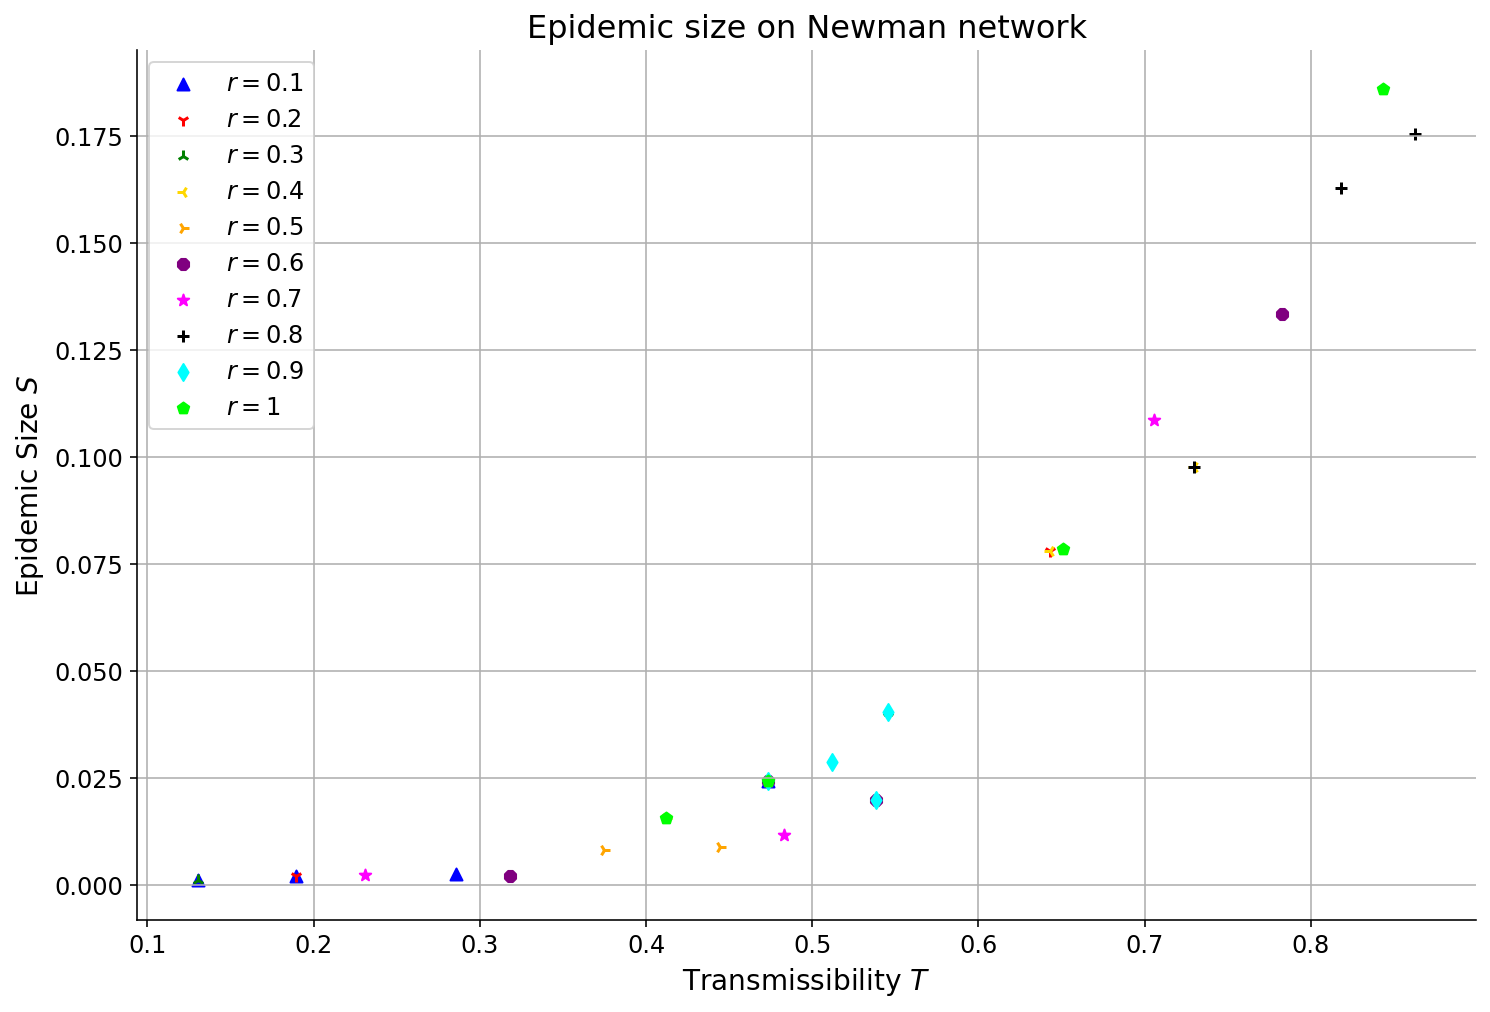

In [63]:
marker_style=["^","1","2","3","4","8","*","+", "d", "p"]
colors=["blue","red","green","gold","orange","purple","magenta","black","cyan", "lime"]

plt.figure( figsize=(12,8))

for i in range(len(betas)):
    S_temp_k10=[]
    T_temp_k10=[]
    for j in range(len(gammas)):
        S_temp_k10.append(S_k10[j*(i+1)])
        T_temp_k10.append(T_k10[j*(i+1)])
    plt.scatter(T_temp_k10,S_temp_k10, marker=marker_style[i], color=colors[i], label=(r"$r= $"+str(betas[i])))
plt.grid()
plt.title("Epidemic size on Newman network")
plt.xlabel("Transmissibility $T$")
plt.ylabel("Epidemic Size $S$")
plt.legend()
plt.show()

In [64]:
T_k5=[]
S_k5=[]
kappa=5
for beta in tqdm(betas):
    for gamma in gammas:
        T_i=0
        S_i=0
        for i in range(num_sim):
            RES=simulation(beta,gamma,kappa,num_nodes)
            #T_i+=RES[0]
            S_i+=RES[1]
        #T_i /= num_sim
        T_i =RES[0]
        S_i /= num_sim
        T_k5.append(T_i)
        S_k5.append(S_i)
        
for i in range(len(S_k5)):
    S_k5[i] = S_k5[i]/num_nodes
    
T_k20=[]
S_k20=[]
kappa=20
for beta in tqdm(betas):
    for gamma in gammas:
        T_i=0
        S_i=0
        for i in range(num_sim):
            RES=simulation(beta,gamma,kappa,num_nodes)
            #T_i+=RES[0]
            S_i+=RES[1]
        #T_i /= num_sim
        T_i =RES[0]
        S_i /= num_sim
        T_k20.append(T_i)
        S_k20.append(S_i)
        
for i in range(len(S_k20)):
    S_k20[i] = S_k20[i]/num_nodes

100%|██████████████████████████████████████████| 10/10 [40:45<00:00, 244.51s/it]


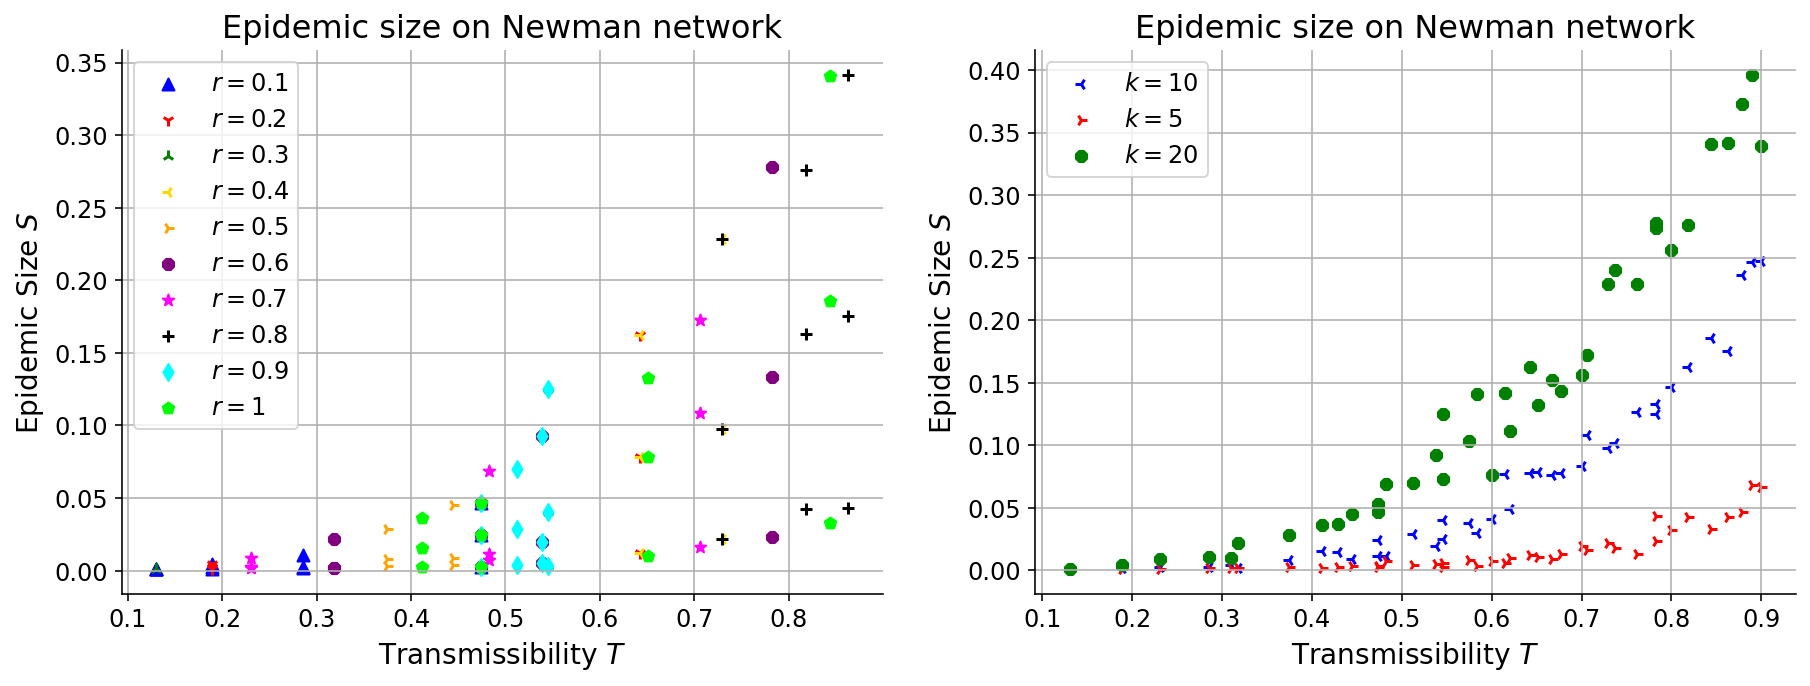

<Figure size 864x576 with 0 Axes>

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


marker_style=["^","1","2","3","4","8","*","+", "d", "p"]
colors=["blue","red","green","gold","orange","purple","magenta","black","cyan", "lime"]

plt.figure( figsize=(12,8))

for i in range(len(betas)):
    S_temp_k10=[]
    T_temp_k10=[]
    for j in range(len(gammas)):
        S_temp_k10.append(S_k10[j*(i+1)])
        T_temp_k10.append(T_k10[j*(i+1)])
    ax[0].scatter(T_temp_k10,S_temp_k10, marker=marker_style[i], color=colors[i], label=(r"$r= $"+str(betas[i])))
    
    S_temp_k5=[]
    T_temp_k5=[]
    for j in range(len(gammas)):
        S_temp_k5.append(S_k5[j*(i+1)])
        T_temp_k5.append(T_k5[j*(i+1)])
    ax[0].scatter(T_temp_k5,S_temp_k5, marker=marker_style[i], color=colors[i])
    
    S_temp_k20=[]
    T_temp_k20=[]
    for j in range(len(gammas)):
        S_temp_k20.append(S_k20[j*(i+1)])
        T_temp_k20.append(T_k20[j*(i+1)])
    ax[0].scatter(T_temp_k20,S_temp_k20, marker=marker_style[i], color=colors[i])



ax[1].scatter(T_k10,S_k10, marker="3", color="blue", label=(r"$k=10$"))
ax[1].scatter(T_k5,S_k5, marker="4", color="red", label=(r"$k=5$"))
ax[1].scatter(T_k20,S_k20, marker="8", color="green", label=(r"$k=20$"))

for ax in ax.flat:
    ax.grid()
    ax.set_title("Epidemic size on Newman network")
    ax.set_xlabel("Transmissibility $T$")
    ax.set_ylabel("Epidemic Size $S$")
    ax.legend()


plt.show()

### Exercise 5.15
Approximately find the critical transmissibility $T_c$ for different values of $\kappa$ in yourr simulations, and compare your results to those of the manuscript. Are they similar? Since we are simulating a smaller system, we do not expect a perfect match, but we do expect a similar qualitative behaviouor.

I due grafici soprastanti sono la stessa simulazione in cui da una parte sottolineo la dipendenza dal rate $r$ di ciascun risultato, mentre dall'altra evidenzio la dipendenza da $k$ dei risultati. In particolare, nel grafico di destra ho riportato l'andamento dell' "Epidemic size" in funzione della trasmissibilità, differenziando le tre curve a diversi valori di $k$. I risultati che ho trovato sono:

- $k=5$  $\rightarrow$  $T_c=0.7$
- $k=10$  $\rightarrow$  $T_c=0.5$
- $k=20$  $\rightarrow$  $T_c=0.3$

Sebbene i risultati non sono in perfetto accordo con i risultati attesi (ho usato meno nodi e meno ripetizioni sul singolo modello per una questione di costo computazionale rispetto alle simulazioni descritte nell'articolo), i risultati numerici da me ottenuti rispecchiano correttamente i comportamenti che si possono leggere sull'articolo.

### Exercise 5.16
Explain why $T_c$ decreases when $\kappa$ is increased. How is this related to the presence of super-spreaders, and how do they impact the global epidemic dynamics?

La distribuzione `get_newman_network` con cui vengono estratte le connessioni dei nodi, o meglio con cui vengono estratti i gradi di ciascun nodo, presenta un cutoff esponenziale al grado $\kappa$. Questo vuol dire che quando $\kappa$ aumenta si hanno un numero maggiori di possibili contatti. Per sistemi con stessa trasmissibilità, la pandemia si espanderà maggiormente nel reticolo in cui si ha più contatti. Pertanto aumentando i contatti basterà una minore trasmissibilità per far crescere la pandemia. Questo è il motivo per cui la $T_c$ diminuisce all'aumentare di $\kappa$.